In [ ]:
# Instalar en el terminal JupyterLab
# Actualiza índices
#conda update -n base -c defaults conda -y

# Instala CatBoost (y XGBoost si falta) desde conda-forge
#conda install -c conda-forge catboost xgboost -y


In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import glob
import os

os.makedirs('./Procesados/finales/', exist_ok=True)
años = ['2020', '2021', '2022', '2023', '2024', '2025']

for año in años:
    final_path = f'./Procesados/finales/DATA_{año}.parquet'

    # Si ya existe el parquet final de ese año, saltar
    if os.path.exists(final_path):
        print(f"Año {año}: ya existe {final_path}. Saltando.\n")
        continue

    archivos = sorted(glob.glob(f'./Procesados/*{año}-*.parquet'))
    print(f"Año {año}: {len(archivos)} archivos encontrados.")
    if not archivos:
        print(f"No hay archivos para {año}, saltando.\n")
        continue

    pqwriter = None
    first = True
    schema_cols = None
    schema_dtypes = None

    try:
        for f in archivos:
            try:
                df = pd.read_parquet(f)

                if first:
                    # Definir esquema base con el primer archivo del año
                    schema_cols = list(df.columns)
                    schema_dtypes = df.dtypes
                    table = pa.Table.from_pandas(df)
                    pqwriter = pq.ParquetWriter(final_path, table.schema)
                    pqwriter.write_table(table)
                    first = False
                    del table, df
                    continue

                # Alinear columnas al esquema base
                for col in schema_cols:
                    if col not in df.columns:
                        df[col] = pd.Series([None] * len(df))
                df = df[schema_cols]

                # Intentar forzar dtypes (sin romper si no se puede)
                for col, dtype in schema_dtypes.items():
                    try:
                        df[col] = df[col].astype(dtype, errors='ignore')
                    except Exception:
                        pass

                table = pa.Table.from_pandas(df)
                pqwriter.write_table(table)
                del table, df

            except Exception as e:
                print(f"Error leyendo {f}: {e}")

        if pqwriter is not None:
            pqwriter.close()
            pqwriter = None
            print(f"Guardado incremental: {final_path}\n")
        else:
            print(f"No se escribió nada para {año}.\n")

    finally:
        # Cierre por seguridad si algo falló antes
        try:
            if pqwriter is not None:
                pqwriter.close()
                pqwriter = None
        except Exception:
            pass

print("Proceso finalizado: Parquet único por año (modo incremental).")


Año 2020: ya existe ./Procesados/finales/DATA_2020.parquet. Saltando.

Año 2021: ya existe ./Procesados/finales/DATA_2021.parquet. Saltando.

Año 2022: ya existe ./Procesados/finales/DATA_2022.parquet. Saltando.

Año 2023: ya existe ./Procesados/finales/DATA_2023.parquet. Saltando.

Año 2024: ya existe ./Procesados/finales/DATA_2024.parquet. Saltando.

Año 2025: 46 archivos encontrados.
Guardado incremental: ./Procesados/finales/DATA_2025.parquet

Proceso finalizado: Parquet único por año (modo incremental).


In [ ]:
import glob
import pandas as pd
archivos = sorted(glob.glob('./Procesados/finales/DATA_*.parquet'))
modelos_set = set()
for f in archivos:
    try:
        # Solo lee la columna 'model' (muy eficiente)
        col_model = pd.read_parquet(f, columns=['model'])
        modelos_set.update(col_model['model'].dropna().unique())
    except Exception as e:
        print(f"Error en {f}: {e}")

modelos_unicos = sorted(list(modelos_set))
print(f"Modelos únicos encontrados: {len(modelos_unicos)}")
print(modelos_unicos)

Modelos únicos encontrados: 97
['CT250MX500SSD1', 'DELLBOSS VD', 'HGST HDS5C4040ALE630', 'HGST HDS724040ALE640', 'HGST HMS5C4040ALE640', 'HGST HMS5C4040BLE640', 'HGST HMS5C4040BLE641', 'HGST HUH721010ALE600', 'HGST HUH721212ALE600', 'HGST HUH721212ALE604', 'HGST HUH721212ALN604', 'HGST HUH728080ALE600', 'HGST HUH728080ALE604', 'HGST HUS726040ALE610', 'HGST HUS726040ALN610', 'HGST HUS728T8TALE6L4', 'HP SSD S700 250GB', 'Hitachi HDS5C4040ALE630', 'MTFDDAV240TCB', 'MTFDDAV240TDU', 'MTFDDAV480TCB', 'MTFDDAV480TDS', 'Micron 5300 MTFDDAK480TDS', 'SSDSCKKB240GZR', 'SSDSCKKB480G8R', 'ST10000NM001G', 'ST10000NM0086', 'ST1000LM024 HN', 'ST12000NM0007', 'ST12000NM0008', 'ST12000NM000J', 'ST12000NM001G', 'ST12000NM003G', 'ST12000NM0117', 'ST14000NM000J', 'ST14000NM0018', 'ST14000NM001G', 'ST14000NM002J', 'ST14000NM0138', 'ST16000NM000J', 'ST16000NM001G', 'ST16000NM002J', 'ST16000NM005G', 'ST18000NM000J', 'ST24000NM002H', 'ST4000DM000', 'ST4000DM004', 'ST4000DM005', 'ST500LM012 HN', 'ST500LM021', '

In [ ]:
import pyarrow.parquet as pq
import glob

archivos = sorted(glob.glob('./Procesados/finales/DATA_*.parquet'))

for archivo in archivos:
    print(f"\n Archivo: {archivo}")
    parquet_file = pq.ParquetFile(archivo)
    schema = parquet_file.schema.to_arrow_schema()  # Convertir a Arrow schema

    # Crear lista con columnas y tipos concatenados
    columnas_con_tipos = []
    for i, col_name in enumerate(schema.names):
        col_type = schema.field(i).type  # Ahora sí funciona field()
        columnas_con_tipos.append(f"{col_name} = {str(col_type)}")

    print(f"Total columnas en archivo '{archivo}': {len(schema.names)}")
    print("Columnas y tipos:", columnas_con_tipos)


 Archivo: ./Procesados/finales/DATA_2020.parquet
Total columnas en archivo './Procesados/finales/DATA_2020.parquet': 131
Columnas y tipos: ['date = timestamp[ns]', 'serial_number = string', 'model = string', 'capacity_bytes = int64', 'failure = int64', 'smart_1_normalized = double', 'smart_1_raw = double', 'smart_2_normalized = double', 'smart_2_raw = double', 'smart_3_normalized = double', 'smart_3_raw = double', 'smart_4_normalized = double', 'smart_4_raw = double', 'smart_5_normalized = double', 'smart_5_raw = double', 'smart_7_normalized = double', 'smart_7_raw = double', 'smart_8_normalized = double', 'smart_8_raw = double', 'smart_9_normalized = double', 'smart_9_raw = double', 'smart_10_normalized = double', 'smart_10_raw = double', 'smart_11_normalized = double', 'smart_11_raw = double', 'smart_12_normalized = double', 'smart_12_raw = double', 'smart_13_normalized = double', 'smart_13_raw = double', 'smart_15_normalized = double', 'smart_15_raw = double', 'smart_16_normalized 

In [ ]:
# -*- coding: utf-8 -*-
import os, glob, re, gc
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import cudf


def final_eda_parquet_chunked_gpu(
    parquet_glob='./Procesados/finales/DATA_*.parquet',
    id_col='serial_number',
    date_col='date',
    label_col='failure',
    model_col='model',
    capacity_col='capacity_bytes',
    rowgroups_per_chunk=1,
    plot_yearly_stackbars=True,
    verbose=True,
):
    """
    EDA robusta y acumulada por row-group en GPU.
    - Devuelve resúmenes por AÑO en una sola fila (totales y por dispositivo).
    - Totales globales por dispositivo (todos los años).
    - Tipos de datos por archivo (matriz tipos x año), # columnas por archivo,
      columnas únicas de cada año y faltantes de cada año.
    - Totales por MODELO (HDD/SSD) sumados en todos los años.

    No usa lookahead. Pensado para datasets grandes (Backblaze-like).
    """

    # =============== Whitelists/Heurísticas (inline para 1 sola func) ===============
    SSD_WHITELIST = set([
        'CT250MX500SSD1','DELLBOSS VD','HP SSD S700 250GB','MTFDDAV240TCB','MTFDDAV240TDU',
        'MTFDDAV480TCB','MTFDDAV480TDS','Micron 5300 MTFDDAK480TDS','SSDSCKKB240GZR',
        'SSDSCKKB480G8R','Samsung SSD 850 EVO 1TB','Samsung SSD 850 PRO 1TB',
        'Samsung SSD 860 PRO 2TB','Samsung SSD 870 EVO 2TB',
        'Seagate BarraCuda 120 SSD ZA250CM10003','Seagate BarraCuda 120 SSD ZA500CM10003',
        'Seagate BarraCuda SSD ZA2000CM10002','Seagate BarraCuda SSD ZA250CM10002',
        'Seagate BarraCuda SSD ZA500CM10002','Seagate FireCuda 120 SSD ZA500GM10001',
        'Seagate IronWolf ZA250NM10002','Seagate SSD','WD Blue SA510 2.5 250GB',
        'WDC  WDS250G2B0A','WDC WDS250G2B0A'
    ])
    HDD_WHITELIST = set([
        'HGST HDS5C4040ALE630','HGST HDS724040ALE640','HGST HMS5C4040ALE640','HGST HMS5C4040BLE640',
        'HGST HMS5C4040BLE641','HGST HUH721010ALE600','HGST HUH721212ALE600','HGST HUH721212ALE604',
        'HGST HUH721212ALN604','HGST HUH728080ALE600','HGST HUH728080ALE604','HGST HUS726040ALE610',
        'HGST HUS726040ALN610','HGST HUS728T8TALE6L4','Hitachi HDS5C4040ALE630',
        'ST10000NM001G','ST10000NM0086','ST1000LM024 HN','ST12000NM0007','ST12000NM0008','ST12000NM000J',
        'ST12000NM001G','ST12000NM003G','ST12000NM0117','ST14000NM000J','ST14000NM0018','ST14000NM001G',
        'ST14000NM002J','ST14000NM0138','ST16000NM000J','ST16000NM001G','ST16000NM002J','ST16000NM005G',
        'ST18000NM000J','ST24000NM002H','ST4000DM000','ST4000DM004','ST4000DM005','ST500LM012 HN',
        'ST500LM021','ST500LM030','ST6000DM001','ST6000DM004','ST6000DX000','ST8000DM002','ST8000DM004',
        'ST8000DM005','ST8000NM000A','ST8000NM0055','TOSHIBA HDWE160','TOSHIBA HDWF180','TOSHIBA MD04ABA400V',
        'TOSHIBA MG07ACA14TA','TOSHIBA MG07ACA14TEY','TOSHIBA MG08ACA16TA','TOSHIBA MG08ACA16TE',
        'TOSHIBA MG08ACA16TEY','TOSHIBA MG09ACA16TE','TOSHIBA MG10ACA20TE','TOSHIBA MQ01ABF050',
        'TOSHIBA MQ01ABF050M','WDC  WUH721414ALE6L4','WDC  WUH721816ALE6L0','WDC  WUH721816ALE6L4',
        'WDC WD5000BPKT','WDC WD5000LPCX','WDC WD5000LPVX','WDC WD60EFRX','WDC WUH721414ALE6L4',
        'WDC WUH721816ALE6L0','WDC WUH721816ALE6L4','WDC WUH722222ALE6L4','WUH721816ALE6L4'
    ])

    def _norm_model(x):
        if x is None:
            return ""
        if not isinstance(x, str):
            x = str(x)
        return re.sub(r"\s+", " ", x.strip())

    # map de whitelist para join exacto
    wl_rows = []
    for m in SSD_WHITELIST:
        wl_rows.append((_norm_model(m).lower(), 'SSD'))
    for m in HDD_WHITELIST:
        wl_rows.append((_norm_model(m).lower(), 'HDD'))
    wl_map = cudf.DataFrame(wl_rows, columns=['model_norm','wl_storage'])

    def _classify_storage(df):
        df['model_norm'] = (
            df[model_col].astype('str')
            .str.strip().str.replace(r"\s+", " ", regex=True).str.lower()
        )
        df = df.merge(wl_map, on='model_norm', how='left')

        s = df['model_norm']
        storage = cudf.Series(['Unknown'] * len(df), index=df.index)

        ssd_mask = (
            s.str.contains(r'\bssd\b') |
            s.str.contains('wds') |
            s.str.contains('sa510') |
            s.str.contains('boss') |
            s.str.contains('ssds') |
            s.str.match(r'^ct') | s.str.match(r'^mtf') | (s.str.contains('mtfd')) |
            s.str.contains('firecuda') |
            (s.str.contains('ironwolf') & s.str.contains('za'))
        )
        storage = storage.where(~ssd_mask, 'SSD')

        hdd_mask = (
            storage.eq('Unknown') & (
                s.str.match(r'^(st|wd|wuh7|hgst|hitachi|toshiba|wuh)') |
                s.str.contains(r'\bhdd\b')
            )
        )
        storage = storage.where(~hdd_mask, 'HDD')

        storage = storage.where(df['wl_storage'].isna(), df['wl_storage'])
        df['storage'] = storage.fillna('Unknown')
        df = df.drop(columns=['wl_storage'])
        return df

    def _classify_mfg(df):
        s = df['model_norm']
        man = cudf.Series(['Other'] * len(df), index=df.index)
        man = man.where(~(s.str.contains('seagate') | s.str.match(r'^st')), 'Seagate')
        man = man.where(~s.str.contains('hgst'), 'HGST')
        man = man.where(~s.str.contains('hitachi'), 'Hitachi')
        man = man.where(~s.str.contains('toshiba'), 'Toshiba')
        man = man.where(~(s.str.contains('western digital') | s.str.contains('wdc') |
                          s.str.match(r'^wd(\s|$)') | s.str.match(r'^(wuh7|wuh)')), 'WDC')
        man = man.where(~s.str.contains('samsung'), 'Samsung')
        man = man.where(~(s.str.contains('micron') | s.str.contains('mtfd') | s.str.match(r'^mtf')), 'Micron')
        man = man.where(~(s.str.contains('crucial') | s.str.match(r'^ct')), 'Crucial')
        man = man.where(~(s.str.contains('intel') | s.str.contains('ssds')), 'Intel')
        man = man.where(~s.str.contains('sandisk'), 'SanDisk')
        man = man.where(~s.str.match(r'^hp\s'), 'HP')
        man = man.where(~(s.str.contains('dell') | s.str.contains('boss')), 'DELL')
        df['manufacturer'] = man
        return df

    def _capacity_tb(series):
        return (series.astype('float64') / 1e12).round(1)

    # ================= Explorar archivos =================
    files = sorted(glob.glob(parquet_glob))
    if verbose:
        print(f"Encontrados {len(files)} archivos.")

    # ---- Info de esquema por año ----
    schema_types_by_year = {}  # year -> {col: type_str}
    ncols_by_year = {}         # year -> n_columns
    cols_by_year = {}          # year -> set(cols)

    # ---- Acumuladores de métricas ----
    # Por año (wide final)
    per_year_totals = {}  # y -> {'rows':..,'fails':..,'nonfails':..}
    per_year_by_storage = {}  # (y,storage) -> {'rows':..,'fails':..}

    # Totales por storage (todos los años)
    storage_totals_all = {}  # storage -> {'rows':..,'fails':..}

    # Modelos HDD/SSD en todos los años
    models_totals = {}  # (storage,model_norm) -> {'rows':..,'fails':..}

    base_cols = [id_col, date_col, label_col, model_col, capacity_col]

    # ================= Procesamiento =================
    for f in files:
        pqf = pq.ParquetFile(f)
        schema = pqf.schema_arrow
        cols_present = [c for c in base_cols if c in schema.names]
        year = int(os.path.splitext(os.path.basename(f))[0].split('_')[-1])

        # Esquema por archivo (sin leer filas)
        types_map = {fld.name: str(fld.type) for fld in schema}
        schema_types_by_year[year] = types_map
        ncols_by_year[year] = len(schema)
        cols_by_year[year] = set(schema.names)

        nrg = pqf.num_row_groups
        if verbose:
            print(f"[{year}] {os.path.basename(f)} → row_groups: {nrg}, cols usadas: {cols_present}")

        # ====== Row-group streaming ======
        rg_idx = 0
        while rg_idx < nrg:
            rg_batch = list(range(rg_idx, min(rg_idx + rowgroups_per_chunk, nrg)))
            rg_idx += rowgroups_per_chunk

            df = cudf.read_parquet(
                f,
                columns=cols_present,
                row_groups=rg_batch,
                use_pandas_metadata=False
            )

            # Fecha
            if date_col in df.columns:
                if not str(df[date_col].dtype).startswith('datetime64'):
                    df[date_col] = df[date_col].astype('datetime64[ns]')
                df = df.dropna(subset=[date_col])
                df['__year__'] = df[date_col].dt.year.astype('int32')
                ycol = int(df['__year__'].iloc[0]) if len(df) else year
            else:
                df['__year__'] = np.int32(year)
                ycol = year

            # Etiqueta falla
            if label_col in df.columns:
                df[label_col] = df[label_col].astype('int8')
            else:
                df[label_col] = 0

            # Modelo/Storage/Manufacturer
            if model_col in df.columns:
                df = _classify_storage(df)
                df = _classify_mfg(df)
            else:
                df['model_norm'] = ''
                df['storage'] = 'Unknown'
                df['manufacturer'] = 'Other'

            # Capacidad (no imprescindible para los totales)
            if capacity_col in df.columns:
                df['capacity_tb'] = _capacity_tb(df[capacity_col])
            else:
                df['capacity_tb'] = cudf.Scalar(np.nan, dtype='float64')

            # ====== Acumular métricas ======
            # Año - totales
            tot_rows = int(len(df))
            tot_fails = int(df[label_col].sum())
            per_year = per_year_totals.get(ycol, {'rows':0,'fails':0,'nonfails':0})
            per_year['rows'] += tot_rows
            per_year['fails'] += tot_fails
            per_year['nonfails'] += (tot_rows - tot_fails)
            per_year_totals[ycol] = per_year

            # Año x storage
            g_st = (df.groupby(['__year__','storage'])[label_col]
                      .agg(['count','sum'])
                      .reset_index()
                      .rename(columns={'count':'rows','sum':'fails'})).to_pandas()
            for _, r in g_st.iterrows():
                k = (int(r['__year__']), r['storage'])
                cur = per_year_by_storage.get(k, {'rows':0,'fails':0})
                cur['rows'] += int(r['rows'])
                cur['fails'] += int(r['fails'])
                per_year_by_storage[k] = cur

                # Totales globales por storage
                ks = r['storage']
                curg = storage_totals_all.get(ks, {'rows':0,'fails':0})
                curg['rows'] += int(r['rows'])
                curg['fails'] += int(r['fails'])
                storage_totals_all[ks] = curg

            # Modelos (solo HDD/SSD) globales
            gm = (df[df['storage'].isin(['HDD','SSD'])]
                    .groupby(['storage','model_norm'])[label_col]
                    .agg(['count','sum'])
                    .reset_index()
                    .rename(columns={'count':'rows','sum':'fails'})).to_pandas()
            for _, r in gm.iterrows():
                k = (r['storage'], r['model_norm'])
                cur = models_totals.get(k, {'rows':0,'fails':0})
                cur['rows'] += int(r['rows'])
                cur['fails'] += int(r['fails'])
                models_totals[k] = cur

            # higiene
            del df, g_st, gm
            gc.collect()

    # ================= Tablas finales =================
    # Años ordenados
    years = sorted(per_year_totals.keys())

    # --- wide por año (una fila por año) ---
    def _get(y, st):
        v = per_year_by_storage.get((y, st), {'rows':0,'fails':0})
        nf = v['rows'] - v['fails']
        fr = (100.0*v['fails']/v['rows']) if v['rows'] else 0.0
        return v['rows'], v['fails'], nf, fr

    rows_wide = []
    for y in years:
        total = per_year_totals[y]
        r_hdd, f_hdd, n_hdd, fr_hdd = _get(y, 'HDD')
        r_ssd, f_ssd, n_ssd, fr_ssd = _get(y, 'SSD')
        r_unk, f_unk, n_unk, fr_unk = _get(y, 'Unknown')
        fr_all = (100.0*total['fails']/total['rows']) if total['rows'] else 0.0
        rows_wide.append({
            'year': y,
            'rows_total': total['rows'],
            'fails_total': total['fails'],
            'nonfails_total': total['nonfails'],
            'fail_rate_total_%': fr_all,
            'rows_HDD': r_hdd, 'fails_HDD': f_hdd, 'nonfails_HDD': n_hdd, 'fail_rate_HDD_%': fr_hdd,
            'rows_SSD': r_ssd, 'fails_SSD': f_ssd, 'nonfails_SSD': n_ssd, 'fail_rate_SSD_%': fr_ssd,
            'rows_Unknown': r_unk, 'fails_Unknown': f_unk, 'nonfails_Unknown': n_unk, 'fail_rate_Unknown_%': fr_unk,
        })
    summary_year_wide = pd.DataFrame(rows_wide).sort_values('year')

    # --- long por año x storage (por si quieres graficar facilmente) ---
    rows_long = []
    for (y, st), v in per_year_by_storage.items():
        nf = v['rows'] - v['fails']
        fr = (100.0*v['fails']/v['rows']) if v['rows'] else 0.0
        rows_long.append({
            'year': y, 'storage': st,
            'rows': v['rows'], 'fails': v['fails'], 'nonfails': nf, 'fail_rate_%': fr
        })
    summary_year_long = pd.DataFrame(rows_long).sort_values(['storage','year'])

    # --- totales globales por dispositivo (todos los años) ---
    rows_stg = []
    for st, v in storage_totals_all.items():
        nf = v['rows'] - v['fails']
        fr = (100.0*v['fails']/v['rows']) if v['rows'] else 0.0
        rows_stg.append({'storage': st, 'rows': v['rows'], 'fails': v['fails'],
                         'nonfails': nf, 'fail_rate_%': fr})
    storage_totals_all_df = pd.DataFrame(rows_stg).sort_values('storage')

    # --- modelos HDD/SSD (todos los años) ---
    rows_mod = []
    for (st, m), v in models_totals.items():
        nf = v['rows'] - v['fails']
        fr = (100.0*v['fails']/v['rows']) if v['rows'] else 0.0
        rows_mod.append({'storage': st, 'model_norm': m, 'rows': v['rows'],
                         'fails': v['fails'], 'nonfails': nf, 'fail_rate_%': fr})
    models_hdd_ssd_totals = (
        pd.DataFrame(rows_mod)
        .sort_values(['storage','rows','fail_rate_%'], ascending=[True, False, False])
        .reset_index(drop=True)
    )

    # --- esquema: # columnas por archivo ---
    schema_summary = pd.DataFrame([{
        'year': y, 'file': os.path.basename(pqf.file_handle.path) if hasattr(pqf, 'file_handle') else '',
        'n_columns': ncols_by_year[y]
    } for y, pqf in zip(sorted(ncols_by_year.keys()), [pq.ParquetFile(files[i]) for i,_ in enumerate(sorted(ncols_by_year.keys()))])]).sort_values('year')

    # --- matriz de tipos (col x año) + presencia ---
    all_cols = sorted(set().union(*[set(d.keys()) for d in schema_types_by_year.values()]))
    type_cols = {}
    for y, tmap in schema_types_by_year.items():
        type_cols[str(y)] = [tmap.get(c, '—') for c in all_cols]
    schema_types_matrix = pd.DataFrame(type_cols, index=all_cols)
    present_counts = (schema_types_matrix != '—').sum(axis=1)
    schema_types_matrix.insert(0, 'present_in_datasets', present_counts.values)

    # --- columnas únicas/faltantes por año ---
    union_cols = set(all_cols)
    columns_unique_by_year = {}
    columns_missing_by_year = {}
    years_sorted = sorted(cols_by_year.keys())
    for y in years_sorted:
        others_union = set().union(*[cols_by_year[yy] for yy in years_sorted if yy != y])
        unique_to_y = sorted(list(cols_by_year[y] - others_union))
        missing_in_y = sorted(list(union_cols - cols_by_year[y]))
        columns_unique_by_year[y] = unique_to_y
        columns_missing_by_year[y] = missing_in_y

    # ================= Gráficas opcionales (barras apiladas) =================
    if plot_yearly_stackbars and len(summary_year_long):
        for st, g in summary_year_long.groupby('storage'):
            g = g.sort_values('year')
            x = g['year'].values
            n1 = g['fails'].values
            n0 = g['nonfails'].values
            plt.figure(figsize=(8,4))
            plt.bar(x, n0, label='No falla (0)')
            plt.bar(x, n1, bottom=n0, label='Falla (1)')
            plt.title(f'{st} · Clases por año (RAW)')
            plt.xlabel('Año'); plt.ylabel('Registros'); plt.legend(); plt.tight_layout(); plt.show()
            plt.close('all')

    return {
        # Resumen “una fila por año”
        'summary_year_wide': summary_year_wide,         # <-- lo que pediste (1 fila por año)
        # Resumen long (útil para gráficas)
        'summary_year_long': summary_year_long,
        # Totales globales por dispositivo
        'storage_totals_all_years': storage_totals_all_df,
        # Totales por modelo (HDD/SSD) en todos los años
        'models_hdd_ssd_totals': models_hdd_ssd_totals,
        # Esquema y diferencias
        'schema_types_matrix': schema_types_matrix,     # tipos por columna y por año
        'schema_ncolumns_by_year': pd.DataFrame(
            [{'year': y, 'n_columns': ncols_by_year[y]} for y in sorted(ncols_by_year)]
        ),
        'columns_unique_by_year': columns_unique_by_year,
        'columns_missing_by_year': columns_missing_by_year,
    }


Encontrados 6 archivos.
[2020] DATA_2020.parquet → row_groups: 92, cols usadas: ['serial_number', 'date', 'failure', 'model', 'capacity_bytes']
[2021] DATA_2021.parquet → row_groups: 92, cols usadas: ['serial_number', 'date', 'failure', 'model', 'capacity_bytes']
[2022] DATA_2022.parquet → row_groups: 8, cols usadas: ['serial_number', 'date', 'failure', 'model', 'capacity_bytes']
[2023] DATA_2023.parquet → row_groups: 116, cols usadas: ['serial_number', 'date', 'failure', 'model', 'capacity_bytes']
[2024] DATA_2024.parquet → row_groups: 182, cols usadas: ['serial_number', 'date', 'failure', 'model', 'capacity_bytes']
[2025] DATA_2025.parquet → row_groups: 90, cols usadas: ['serial_number', 'date', 'failure', 'model', 'capacity_bytes']


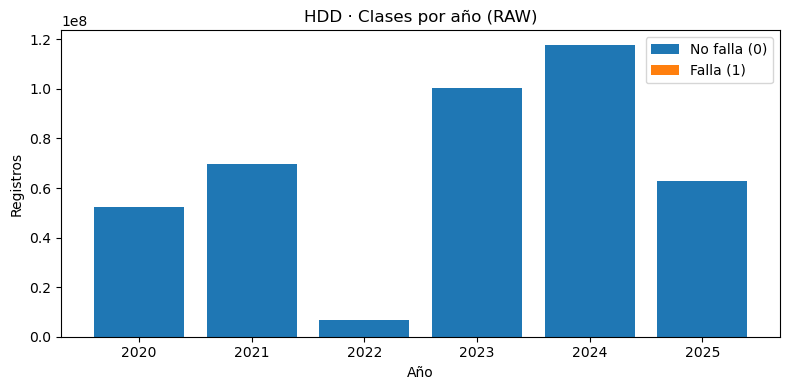

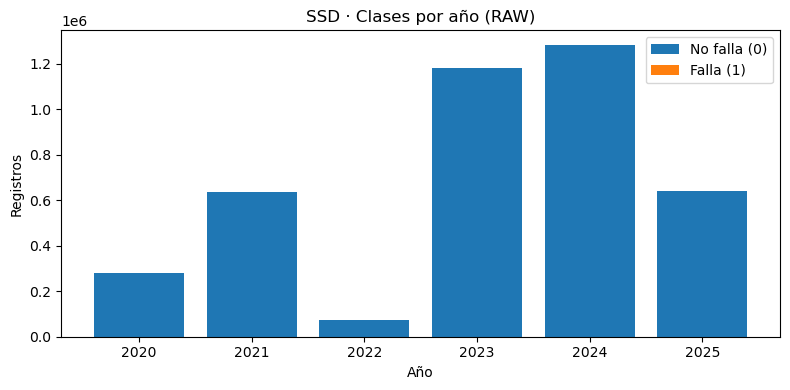

{2020: ['cluster_id',
  'datacenter',
  'is_legacy_format',
  'pod_id',
  'pod_slot_num',
  'smart_160_normalized',
  'smart_160_raw',
  'smart_161_normalized',
  'smart_161_raw',
  'smart_163_normalized',
  'smart_163_raw',
  'smart_164_normalized',
  'smart_164_raw',
  'smart_165_normalized',
  'smart_165_raw',
  'smart_166_normalized',
  'smart_166_raw',
  'smart_167_normalized',
  'smart_167_raw',
  'smart_169_normalized',
  'smart_169_raw',
  'smart_171_normalized',
  'smart_171_raw',
  'smart_172_normalized',
  'smart_172_raw',
  'smart_175_normalized',
  'smart_175_raw',
  'smart_176_normalized',
  'smart_176_raw',
  'smart_178_normalized',
  'smart_178_raw',
  'smart_180_normalized',
  'smart_180_raw',
  'smart_202_normalized',
  'smart_202_raw',
  'smart_206_normalized',
  'smart_206_raw',
  'smart_210_normalized',
  'smart_210_raw',
  'smart_211_normalized',
  'smart_211_raw',
  'smart_212_normalized',
  'smart_212_raw',
  'smart_230_normalized',
  'smart_230_raw',
  'smart_2

In [ ]:
res = final_eda_parquet_chunked_gpu(
    parquet_glob='./Procesados/finales/DATA_*.parquet',
    rowgroups_per_chunk=8,            # 1 si tu GPU es justita; 2–4 si puedes
    plot_yearly_stackbars=True,
    verbose=True
)

# 1 fila por año (totales y por dispositivo):
res['summary_year_wide']

# Totales por dispositivo (todos los años):
res['storage_totals_all_years']

# Fallas / no-fallas por MODELO (HDD/SSD), sumado en todos los años:
res['models_hdd_ssd_totals']

# Tipos por columna y por año:
res['schema_types_matrix']

# Número de columnas por dataset (año):
res['schema_ncolumns_by_year']

# Columnas únicas/faltantes por año:
res['columns_unique_by_year']
res['columns_missing_by_year']


In [ ]:
def clean_2020_2024_parquet_gpu_simple(
    parquet_glob="./Procesados/finales/DATA_*.parquet",
    years=(2020, 2021, 2022, 2023, 2024),
    out_hdd="./Procesados/finales/HDD_FULL_CLEAN.parquet",
    out_ssd="./Procesados/finales/SSD_FULL_CLEAN.parquet",
    chunk_rows=2_000_000,   # <--- ÚNICO knob: tamaño de lectura por archivo (en filas)
    verbose=True,
):
    """
    Unifica DATA_YYYY.parquet (2020–2024, excluye 2025) en GPU -> 1 archivo HDD y 1 archivo SSD.
    Sin Dask, sin bytes_per_thread, sin inicializaciones RMM manuales.
    """
    import os, glob, shutil, uuid
    import cudf
    import pyarrow as pa
    import pyarrow.parquet as pq
    import pyarrow.dataset as ds

    # Catálogos
    ssd_models = [
        'CT250MX500SSD1','DELLBOSS VD','HP SSD S700 250GB','MTFDDAV240TCB','MTFDDAV240TDU',
        'MTFDDAV480TCB','MTFDDAV480TDS','Micron 5300 MTFDDAK480TDS','SSDSCKKB240GZR',
        'SSDSCKKB480G8R','Samsung SSD 850 EVO 1TB','Samsung SSD 860 PRO 2TB',
        'Seagate BarraCuda 120 SSD ZA250CM10003','Seagate BarraCuda 120 SSD ZA500CM10003',
        'Seagate BarraCuda SSD ZA2000CM10002','Seagate BarraCuda SSD ZA250CM10002',
        'Seagate BarraCuda SSD ZA500CM10002','Seagate FireCuda 120 SSD ZA500GM10001',
        'Seagate IronWolf ZA250NM10002','Seagate SSD','WD Blue SA510 2.5 250GB',
        'WDC  WDS250G2B0A','WDC WDS250G2B0A'
    ]
    hdd_models = [
        'HGST HDS5C4040ALE630','HGST HDS724040ALE640','HGST HMS5C4040ALE640',
        'HGST HMS5C4040BLE640','HGST HMS5C4040BLE641','HGST HUH721010ALE600',
        'HGST HUH721212ALE600','HGST HUH721212ALE604','HGST HUH721212ALN604',
        'HGST HUH728080ALE600','HGST HUH728080ALE604','HGST HUS726040ALE610',
        'HGST HUS726040ALN610','HGST HUS728T8TALE6L4','Hitachi HDS5C4040ALE630',
        'ST10000NM001G','ST10000NM0086','ST1000LM024 HN','ST12000NM0007','ST12000NM0008',
        'ST12000NM000J','ST12000NM001G','ST12000NM003G','ST12000NM0117','ST14000NM000J',
        'ST14000NM0018','ST14000NM001G','ST14000NM002J','ST14000NM0138','ST16000NM000J',
        'ST16000NM001G','ST16000NM002J','ST16000NM005G','ST18000NM000J','ST24000NM002H',
        'ST4000DM000','ST4000DM004','ST4000DM005','ST500LM012 HN','ST500LM021','ST500LM030',
        'ST6000DM001','ST6000DM004','ST6000DX000','ST8000DM002','ST8000DM004','ST8000DM005',
        'ST8000NM000A','ST8000NM0055','TOSHIBA HDWE160','TOSHIBA HDWF180',
        'TOSHIBA MD04ABA400V','TOSHIBA MG07ACA14TA','TOSHIBA MG07ACA14TEY',
        'TOSHIBA MG08ACA16TA','TOSHIBA MG08ACA16TE','TOSHIBA MG08ACA16TEY',
        'TOSHIBA MG09ACA16TE','TOSHIBA MG10ACA20TE','TOSHIBA MQ01ABF050',
        'TOSHIBA MQ01ABF050M','WDC  WUH721414ALE6L4','WDC  WUH721816ALE6L0',
        'WDC  WUH721816ALE6L4','WDC WD5000BPKT','WDC WD5000LPCX','WDC WD5000LPVX',
        'WDC WD60EFRX','WDC WUH721414ALE6L4','WDC WUH721816ALE6L0','WDC WUH721816ALE6L4',
        'WDC WUH722222ALE6L4','WUH721816ALE6L4'
    ]
    features_hdd = ['smart_5_raw','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw']
    features_ssd = [
        'smart_5_raw','smart_187_raw','smart_194_raw','smart_231_raw','smart_233_raw',
        'smart_241_raw','smart_242_raw','smart_9_raw','smart_173_raw','smart_174_raw',
        'smart_184_raw','smart_199_raw','smart_230_raw'
    ]
    base_cols = ['model','date','failure','serial_number','capacity_bytes']
    final_hdd_cols = base_cols + [c for c in features_hdd if c not in base_cols]
    final_ssd_cols = base_cols + [c for c in features_ssd if c not in base_cols]
    union_features = sorted(set(features_hdd) | set(features_ssd))

    # Helpers
    def _ensure_cols_cast(gdf, final_cols, features):
        # faltantes
        for col in final_cols:
            if col not in gdf.columns:
                if col in features:
                    gdf[col] = 0.0
                elif col == 'failure':
                    gdf[col] = 0
                elif col == 'date':
                    gdf[col] = cudf.Series([None] * len(gdf))
                    gdf[col] = cudf.to_datetime(gdf[col])
                elif col == 'capacity_bytes':
                    gdf[col] = 0
                else:
                    gdf[col] = ""
        # cast
        if 'date' in final_cols:
            gdf['date'] = cudf.to_datetime(gdf['date'].astype('str'))
        if 'failure' in final_cols:
            gdf['failure'] = gdf['failure'].fillna(0).astype('int8')
        for f in features:
            if f in gdf.columns:
                gdf[f] = gdf[f].astype('float32').fillna(0)
        if 'capacity_bytes' in final_cols:
            gdf['capacity_bytes'] = gdf['capacity_bytes'].fillna(0).astype('int64')
        if 'serial_number' in final_cols:
            gdf['serial_number'] = gdf['serial_number'].astype('str')
        if 'model' in final_cols:
            gdf['model'] = gdf['model'].astype('str')
        return gdf[final_cols]

    def _write_part(gdf, tmp_dir, prefix):
        if len(gdf) == 0:
            return
        part = f"{prefix}-{uuid.uuid4().hex}.parquet"
        gdf.to_parquet(os.path.join(tmp_dir, part), compression="snappy", index=False)

    def _compact_dir_to_single(src_dir, out_file, columns_order):
        files = glob.glob(os.path.join(src_dir, "*.parquet"))
        if not files:
            # escribe archivo vacío con esquema correcto
            arrays = []
            for c in columns_order:
                if c == 'date':
                    arrays.append(pa.array([], type=pa.timestamp('ns')))
                elif c == 'failure':
                    arrays.append(pa.array([], type=pa.int8()))
                elif c in ('model','serial_number'):
                    arrays.append(pa.array([], type=pa.string()))
                elif c == 'capacity_bytes':
                    arrays.append(pa.array([], type=pa.int64()))
                else:
                    arrays.append(pa.array([], type=pa.float32()))
            pq.write_table(pa.Table.from_arrays(arrays, names=columns_order), out_file, compression="snappy")
            return
        dataset = ds.dataset(src_dir, format="parquet")
        writer = None
        for batch in dataset.to_batches(columns=columns_order):
            table = pa.Table.from_batches([batch])
            if writer is None:
                writer = pq.ParquetWriter(out_file, table.schema, compression="snappy")
            writer.write_table(table)
        if writer:
            writer.close()
        shutil.rmtree(src_dir, ignore_errors=True)

    # Preparar salidas temporales
    os.makedirs(os.path.dirname(out_hdd), exist_ok=True)
    tmp_hdd_dir = out_hdd + ".parts"
    tmp_ssd_dir = out_ssd + ".parts"
    for d in (tmp_hdd_dir, tmp_ssd_dir):
        if os.path.exists(d):
            shutil.rmtree(d, ignore_errors=True)
        os.makedirs(d, exist_ok=True)

    # Resolver archivos 2020–2024 (excluye 2025)
    all_files = sorted(glob.glob(parquet_glob))
    years_str = tuple(str(y) for y in years)
    files = [f for f in all_files if any(y in os.path.basename(f) for y in years_str) and "2025" not in f]
    if not files:
        raise FileNotFoundError("No se encontraron DATA_YYYY.parquet para 2020–2024.")

    if verbose:
        print(f"Archivos a procesar: {len(files)} — {files[:3]}{' ...' if len(files)>3 else ''}")

    # Proceso por archivo, en bloques de filas grandes (chunk_rows)
    parts_hdd = parts_ssd = 0
    for fpath in files:
        pf = pq.ParquetFile(fpath)
        schema_cols = set(pf.schema.names)
        if 'model' not in schema_cols:
            if verbose: print(f"   [skip] {os.path.basename(fpath)} sin columna 'model'")
            continue
        cols_to_read = [c for c in (set(base_cols) | set(union_features)) if c in schema_cols]
        total_rows = pf.metadata.num_rows
        if verbose:
            print(f"\n→ {os.path.basename(fpath)} | cols a leer: {len(cols_to_read)} | filas: {total_rows}")

        offset = 0
        while offset < total_rows:
            take = min(chunk_rows, total_rows - offset)
            gdf_all = cudf.read_parquet(fpath, columns=cols_to_read, skip_rows=offset, nrows=take)

            # HDD
            gdf_hdd = gdf_all[gdf_all['model'].isin(hdd_models)]
            if len(gdf_hdd):
                gdf_hdd = _ensure_cols_cast(gdf_hdd, final_hdd_cols, features_hdd)
                _write_part(gdf_hdd, tmp_hdd_dir, f"HDD-{os.path.basename(fpath)}-rows{offset}to{offset+take}")
                parts_hdd += 1

            # SSD
            gdf_ssd = gdf_all[gdf_all['model'].isin(ssd_models)]
            if len(gdf_ssd):
                gdf_ssd = _ensure_cols_cast(gdf_ssd, final_ssd_cols, features_ssd)
                _write_part(gdf_ssd, tmp_ssd_dir, f"SSD-{os.path.basename(fpath)}-rows{offset}to{offset+take}")
                parts_ssd += 1

            offset += take

    if verbose:
        print(f"\nPartes generadas → HDD: {parts_hdd} · SSD: {parts_ssd}")

    # Compactar a un solo archivo por tipo (streaming, sin cargar todo)
    _compact_dir_to_single(tmp_hdd_dir, out_hdd, final_hdd_cols)
    _compact_dir_to_single(tmp_ssd_dir, out_ssd, final_ssd_cols)

    # Reporte
    def _stat(p):
        try:
            return f"{os.path.getsize(p)/1024/1024:.2f} MB"
        except Exception:
            return "N/A"
    print("✔ Unificación 2020–2024 completada.")
    print(f"  HDD → {out_hdd} ({_stat(out_hdd)})")
    print(f"  SSD → {out_ssd} ({_stat(out_ssd)})")


In [ ]:
# seguro y rápido en una GPU de 6 GB:
clean_2020_2024_parquet_gpu_simple(
    chunk_rows=2_000_000,  # sube a 3_000_000 si ves VRAM libre; baja a 1_000_000 si te falta
    verbose=True
)


Archivos a procesar: 5 — ['./Procesados/finales/DATA_2020.parquet', './Procesados/finales/DATA_2021.parquet', './Procesados/finales/DATA_2022.parquet'] ...

→ DATA_2020.parquet | cols a leer: 20 | filas: 52286398

→ DATA_2021.parquet | cols a leer: 20 | filas: 67294340

→ DATA_2022.parquet | cols a leer: 21 | filas: 6622836

→ DATA_2023.parquet | cols a leer: 21 | filas: 91683133

→ DATA_2024.parquet | cols a leer: 21 | filas: 105379761

Partes generadas → HDD: 164 · SSD: 164
✔ Unificación 2020–2024 completada.
  HDD → ./Procesados/finales/HDD_FULL_CLEAN.parquet (2640.77 MB)
  SSD → ./Procesados/finales/SSD_FULL_CLEAN.parquet (68.88 MB)


In [ ]:
def clean_2025_parquet_gpu(
    parquet_path="./Procesados/finales/DATA_2025.parquet",
    out_hdd="./Procesados/finales/HDD_FULL_CLEAN_2025.parquet",
    out_ssd="./Procesados/finales/SSD_FULL_CLEAN_2025.parquet",
    verbose=True
):
    """
    Limpia y estandariza el DATA_2025.parquet en GPU (RAPIDS),
    y genera dos archivos Parquet finales (HDD y SSD), con columnas y tipos homogéneos.

    Requisitos (imagen RAPIDS 24.08):
      - cudf, dask_cudf, pyarrow (ya vienen en rapidsai/jupyter:24.08-cuda12.5-py3.11)

    Notas:
      - Usa Dask-cuDF para procesar en GPU.
      - Escribe a un directorio temporal y luego renombra al .parquet de salida (archivo único).
      - Si una feature no existe, se crea con 0.0.
      - Tipos: failure -> int8, features -> float32, date -> datetime64[ns], capacity_bytes -> int64.
    """
    import os, glob, shutil, tempfile
    import numpy as np
    import pyarrow.parquet as pq
    import cudf
    import dask_cudf as dc

    # 0) Cliente Dask (GPU) opcional
    try:
        from dask_cuda import LocalCUDACluster
        from dask.distributed import Client
        # Evita múltiples clusters si llamas varias veces en el mismo cuaderno
        _client = Client.current()
        if _client is None:
            cluster = LocalCUDACluster()
            client = Client(cluster)
    except Exception:
        # Fallback (igual aprovechará cuDF en las particiones)
        try:
            from dask.distributed import Client
            _client = Client.current()
            if _client is None:
                client = Client()
        except Exception:
            pass  # Dask usará scheduler por defecto

    os.makedirs(os.path.dirname(out_hdd), exist_ok=True)

    # 1) Catálogos de modelos y features
    ssd_models = [
        'CT250MX500SSD1','DELLBOSS VD','HP SSD S700 250GB','MTFDDAV240TCB','MTFDDAV240TDU',
        'MTFDDAV480TCB','MTFDDAV480TDS','Micron 5300 MTFDDAK480TDS','SSDSCKKB240GZR',
        'SSDSCKKB480G8R','Samsung SSD 850 EVO 1TB','Samsung SSD 860 PRO 2TB',
        'Seagate BarraCuda 120 SSD ZA250CM10003','Seagate BarraCuda 120 SSD ZA500CM10003',
        'Seagate BarraCuda SSD ZA2000CM10002','Seagate BarraCuda SSD ZA250CM10002',
        'Seagate BarraCuda SSD ZA500CM10002','Seagate FireCuda 120 SSD ZA500GM10001',
        'Seagate IronWolf ZA250NM10002','Seagate SSD','WD Blue SA510 2.5 250GB',
        'WDC  WDS250G2B0A','WDC WDS250G2B0A'
    ]
    hdd_models = [
        'HGST HDS5C4040ALE630','HGST HDS724040ALE640','HGST HMS5C4040ALE640',
        'HGST HMS5C4040BLE640','HGST HMS5C4040BLE641','HGST HUH721010ALE600',
        'HGST HUH721212ALE600','HGST HUH721212ALE604','HGST HUH721212ALN604',
        'HGST HUH728080ALE600','HGST HUH728080ALE604','HGST HUS726040ALE610',
        'HGST HUS726040ALN610','HGST HUS728T8TALE6L4','Hitachi HDS5C4040ALE630',
        'ST10000NM001G','ST10000NM0086','ST1000LM024 HN','ST12000NM0007','ST12000NM0008',
        'ST12000NM000J','ST12000NM001G','ST12000NM003G','ST12000NM0117','ST14000NM000J',
        'ST14000NM0018','ST14000NM001G','ST14000NM002J','ST14000NM0138','ST16000NM000J',
        'ST16000NM001G','ST16000NM002J','ST16000NM005G','ST18000NM000J','ST24000NM002H',
        'ST4000DM000','ST4000DM004','ST4000DM005','ST500LM012 HN','ST500LM021','ST500LM030',
        'ST6000DM001','ST6000DM004','ST6000DX000','ST8000DM002','ST8000DM004','ST8000DM005',
        'ST8000NM000A','ST8000NM0055','TOSHIBA HDWE160','TOSHIBA HDWF180',
        'TOSHIBA MD04ABA400V','TOSHIBA MG07ACA14TA','TOSHIBA MG07ACA14TEY',
        'TOSHIBA MG08ACA16TA','TOSHIBA MG08ACA16TE','TOSHIBA MG08ACA16TEY',
        'TOSHIBA MG09ACA16TE','TOSHIBA MG10ACA20TE','TOSHIBA MQ01ABF050',
        'TOSHIBA MQ01ABF050M','WDC  WUH721414ALE6L4','WDC  WUH721816ALE6L0',
        'WDC  WUH721816ALE6L4','WDC WD5000BPKT','WDC WD5000LPCX','WDC WD5000LPVX',
        'WDC WD60EFRX','WDC WUH721414ALE6L4','WDC WUH721816ALE6L0','WDC WUH721816ALE6L4',
        'WDC WUH722222ALE6L4','WUH721816ALE6L4'
    ]

    features_hdd = ['smart_5_raw','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw']
    features_ssd = [
        'smart_5_raw','smart_187_raw','smart_194_raw','smart_231_raw','smart_233_raw',
        'smart_241_raw','smart_242_raw','smart_9_raw','smart_173_raw','smart_174_raw',
        'smart_184_raw','smart_199_raw','smart_230_raw'
    ]
    base_cols = ['model','date','failure','serial_number','capacity_bytes']

    # Helper: DataFrame vacío con esquema correcto (para caso "sin filas")
    def _empty_gpu_df(final_cols, features):
        dtypes = {}
        for c in final_cols:
            if c in features:
                dtypes[c] = 'float32'
            elif c == 'failure':
                dtypes[c] = 'int8'
            elif c == 'date':
                dtypes[c] = 'datetime64[ns]'
            elif c == 'capacity_bytes':
                dtypes[c] = 'int64'
            elif c in ('model','serial_number'):
                dtypes[c] = 'str'
            else:
                dtypes[c] = 'str'
        return cudf.DataFrame({col: cudf.Series([], dtype=dt) for col, dt in dtypes.items()})

    # Helper: normalizar columnas/tipos y orden
    def _ensure_columns_and_types(ddf, final_cols, features, kind="HDD"):
        def _pad(df):
            for col in final_cols:
                if col not in df.columns:
                    if col in features:
                        df[col] = 0.0
                    elif col == 'failure':
                        df[col] = 0
                    elif col == 'date':
                        df[col] = cudf.to_datetime(None)
                    elif col == 'capacity_bytes':
                        df[col] = 0
                    else:
                        df[col] = ""
            return df

        ddf = ddf.map_partitions(_pad)

        # Casts
        # date (cuDF no soporta errors='coerce' en Series)
        if 'date' in final_cols:
            def _fix_date(df):
                # Convierte a string primero por si viene como int/obj, y luego a datetime
                if 'date' in df.columns:
                    df['date'] = cudf.to_datetime(df['date'].astype('str'))
                return df
            ddf = ddf.map_partitions(_fix_date)

        if 'failure' in final_cols:
            ddf['failure'] = ddf['failure'].fillna(0).astype('int8')

        for f in features:
            if f in final_cols:
                ddf[f] = ddf[f].astype('float32').fillna(0)

        if 'capacity_bytes' in final_cols:
            ddf['capacity_bytes'] = ddf['capacity_bytes'].fillna(0).astype('int64')

        if 'serial_number' in final_cols:
            ddf['serial_number'] = ddf['serial_number'].astype('str')
        if 'model' in final_cols:
            ddf['model'] = ddf['model'].astype('str')

        ddf = ddf[final_cols]
        return ddf

    # Helper: escribir realmente un solo archivo con nombre exacto
    def _write_single_file(ddf, out_path):
        """
        Escribe un único archivo Parquet:
        1) Reparte a 1 partición (para no inflar memoria intermedia).
        2) Materializa a cuDF con .compute() (queda en GPU).
        3) Escribe con el writer de cuDF (sin PyArrow), a un solo .parquet.
        """
        import os, shutil

        # 1) Forzamos 1 partición (menos overhead antes de .compute)
        ddf1 = ddf.repartition(npartitions=1)

        # 2) Materializamos en GPU (cuDF.DataFrame)
        gdf = ddf1.compute()          # <- devuelve cudf.DataFrame
        # (si no entrara en memoria, ver nota al final)

        # 3) Escribir directo con cuDF (archivo único)
        if os.path.exists(out_path):
            os.remove(out_path)
        gdf.to_parquet(out_path, compression="snappy", index=False)

        # Limpieza explícita
        del gdf



    # 2) Validaciones básicas + columnas existentes
    if not os.path.exists(parquet_path):
        raise FileNotFoundError(f"No existe el archivo de entrada: {parquet_path}")

    pqf = pq.ParquetFile(parquet_path)
    existing_cols = set(pqf.schema.names)

    cols_hdd_read = [c for c in (set(base_cols) | set(features_hdd)) if c in existing_cols]
    cols_ssd_read = [c for c in (set(base_cols) | set(features_ssd)) if c in existing_cols]

    if verbose:
        print(f"Entradas detectadas en {parquet_path}: {len(existing_cols)} columnas")
        print(f"HDD leerá: {cols_hdd_read}")
        print(f"SSD leerá: {cols_ssd_read}")

    # 3) HDD
    final_hdd_cols = base_cols + [c for c in features_hdd if c not in base_cols]
    if cols_hdd_read:
        ddf_hdd = dc.read_parquet(parquet_path, columns=cols_hdd_read)
        ddf_hdd = ddf_hdd[ddf_hdd['model'].isin(hdd_models)]
        # Conteo rápido
        try:
            cnt_hdd = int(ddf_hdd['model'].count().compute())
        except Exception:
            cnt_hdd = -1
        if verbose:
            print(f"HDD filas tras filtrar modelos: {cnt_hdd}")
        if cnt_hdd == 0:
            if verbose: print("HDD sin filas; se escribirá esquema vacío.")
            empty_hdd = _empty_gpu_df(final_hdd_cols, features_hdd)
            empty_hdd.to_parquet(out_hdd, compression="snappy")
        else:
            ddf_hdd = _ensure_columns_and_types(ddf_hdd, final_hdd_cols, features_hdd, kind="HDD")
            _write_single_file(ddf_hdd, out_hdd)
    else:
        if verbose: print("HDD: No hay columnas requeridas; se escribe archivo vacío.")
        empty_hdd = _empty_gpu_df(final_hdd_cols, features_hdd)
        empty_hdd.to_parquet(out_hdd, compression="snappy")

    # 4) SSD
    final_ssd_cols = base_cols + [c for c in features_ssd if c not in base_cols]
    if cols_ssd_read:
        ddf_ssd = dc.read_parquet(parquet_path, columns=cols_ssd_read)
        ddf_ssd = ddf_ssd[ddf_ssd['model'].isin(ssd_models)]
        try:
            cnt_ssd = int(ddf_ssd['model'].count().compute())
        except Exception:
            cnt_ssd = -1
        if verbose:
            print(f"SSD filas tras filtrar modelos: {cnt_ssd}")
        if cnt_ssd == 0:
            if verbose: print("SSD sin filas; se escribirá esquema vacío.")
            empty_ssd = _empty_gpu_df(final_ssd_cols, features_ssd)
            empty_ssd.to_parquet(out_ssd, compression="snappy")
        else:
            ddf_ssd = _ensure_columns_and_types(ddf_ssd, final_ssd_cols, features_ssd, kind="SSD")
            _write_single_file(ddf_ssd, out_ssd)
    else:
        if verbose: print("SSD: No hay columnas requeridas; se escribe archivo vacío.")
        empty_ssd = _empty_gpu_df(final_ssd_cols, features_ssd)
        empty_ssd.to_parquet(out_ssd, compression="snappy")

    # 5) Confirmación final
    def _stat(p):
        try:
            sz = os.path.getsize(p)
            return f"{sz/1024/1024:.2f} MB"
        except Exception:
            return "N/A"
    print("✔ Limpieza GPU completada.")
    print(f"  HDD → {out_hdd} ({_stat(out_hdd)})")
    print(f"  SSD → {out_ssd} ({_stat(out_ssd)})")


In [ ]:
clean_2025_parquet_gpu()

Entradas detectadas en ./Procesados/finales/DATA_2025.parquet: 197 columnas
HDD leerá: ['date', 'capacity_bytes', 'serial_number', 'smart_188_raw', 'failure', 'smart_198_raw', 'smart_197_raw', 'smart_5_raw', 'smart_187_raw', 'model']
SSD leerá: ['smart_173_raw', 'date', 'smart_233_raw', 'capacity_bytes', 'smart_194_raw', 'failure', 'smart_184_raw', 'smart_9_raw', 'smart_231_raw', 'smart_230_raw', 'model', 'smart_242_raw', 'serial_number', 'smart_199_raw', 'smart_5_raw', 'smart_174_raw', 'smart_241_raw', 'smart_187_raw']
HDD filas tras filtrar modelos: 55999545
SSD filas tras filtrar modelos: 608296
✔ Limpieza GPU completada.
  HDD → ./Procesados/finales/HDD_FULL_CLEAN_2025.parquet (312.53 MB)
  SSD → ./Procesados/finales/SSD_FULL_CLEAN_2025.parquet (7.86 MB)


In [ ]:
# -*- coding: utf-8 -*-
import os, warnings, gc
warnings.filterwarnings("ignore")

import dask
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

import dask_cudf as dc
import cudf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def eda_backblaze_pro_gpu(
    parquet_train_path,
    parquet_test2025_path=None,
    dataset_name='SSD',
    id_col='serial_number',
    date_col='date',
    label_col='failure',
    model_col='model',
    capacity_col='capacity_bytes',   # no lo explotamos, pero no estorba
    lookahead_grid=None,             # p.ej.: [0,2,3,7] SSD | [0,3,7,14,30] HDD
    rmm_pool_size="4.0GB",
    device_memory_limit="4.0GB",
    enable_cudf_spill=True,
    plot=True,                       # True => hace gráficas
    verbose=True,
    top_plot_models=20               # cuántos modelos mostrar en la gráfica
):
    """
    EDA Backblaze en GPU (cuDF + Dask-cuDF) con:
      - Overview extendido (totales + por año).
      - Incidencias por AÑO y por MODELO (n0, n1, rows, %fallas).
      - Recuentos por MODELO (rows, discos, fallos) + gráfica (top N).
      - Estadísticas por disco (días observados).
      - Lookahead (tasa de positivos en <= N días).

    Anti-errores:
      • Shuffle P2P desactivado (usamos "tasks").
      • Claves en string (sin category).
      • Pivots/merges en pandas post-compute.
      • days_obs en pandas con .dt.days (evita timedelta64[D]).
      • Lookahead 100% en dask_cudf (nada de construir cudf.DataFrame con Series Dask).
    """
    # ---------- Config Dask: evitar P2P shuffle ----------
    dask.config.set({"dataframe.shuffle.method": "tasks"})

    # ----------------------------
    # 0) Cluster local (1 GPU)
    # ----------------------------
    cluster = LocalCUDACluster(
        n_workers=1,
        threads_per_worker=1,
        device_memory_limit=device_memory_limit,
        rmm_pool_size=rmm_pool_size,
        enable_cudf_spill=enable_cudf_spill,
        local_directory=os.environ.get("DASK_TEMPORARY_DIRECTORY", "./.dask-tmp")
    )
    client = Client(cluster)
    if verbose:
        print(client)

    # ----------------------------
    # Helpers
    # ----------------------------
    def _ensure_datetime_cu(ddf, col, fmt=None):
        """Convierte a datetime64 por partición."""
        def _cast_part(g):
            s = g[col]
            if str(s.dtype).startswith("datetime64"):
                return g
            try:
                g[col] = cudf.to_datetime(s, format=fmt)
            except Exception:
                try:
                    g[col] = cudf.to_datetime(s.astype('str'), format=fmt)
                except Exception:
                    g[col] = cudf.to_datetime(cudf.Series([''] * len(g)))
                    g[col] = g[col].where(False)  # all NaT
            return g
        out = ddf.map_partitions(_cast_part)
        out = out.dropna(subset=[col])
        return out

    def _overview_gpu(ddf_part):
        rows = int(ddf_part.shape[0].compute())
        ncols = int(len(ddf_part.columns))
        unique_disks = int(ddf_part[id_col].nunique().compute())
        dt_min = ddf_part[date_col].min().compute()
        dt_max = ddf_part[date_col].max().compute()
        years = sorted(pd.unique(ddf_part[date_col].dt.year.astype('int16').compute().to_pandas()).tolist())
        failures = int(ddf_part[label_col].sum().compute())
        n0 = rows - failures
        fail_rate_rows = 100.0 * failures / rows if rows else 0.0
        return {
            'rows': rows,
            'cols': ncols,
            'unique_disks': unique_disks,
            'date_min': dt_min,
            'date_max': dt_max,
            'years': years,
            'n0': n0,
            'n1': failures,
            'fail_rate_rows_%': fail_rate_rows
        }

    def _lookahead_rate_gpu(g, N_days):
        """
        % de pares (serial, date) que tienen una falla en <= N días.
        *** Implementación 100% dask_cudf (sin cuDF directo). ***
        """
        # Subtabla minimizada
        base  = g[[id_col, date_col, label_col]]
        # fallas por (serial, fecha de falla)
        fails = base[base[label_col] == 1][[id_col, date_col]].rename(columns={date_col: 'fail_date'})
        # join por serial
        merged = base[[id_col, date_col]].merge(fails, on=id_col, how='left')
        # diferencia temporal
        diff = (merged['fail_date'] - merged[date_col])  # timedelta64[ns] con NaT permitido
        # condición sin convertir a int: comparar con np.timedelta64 para evitar astype
        hit = (diff >= np.timedelta64(0, 'ns')) & (diff <= np.timedelta64(N_days, 'D'))
        # agrega columna hit (int8) en Dask-cuDF
        merged = merged.assign(hit=hit.fillna(False).astype('int8'))
        # colapsa por (serial, fecha observación)
        hits_max = (merged.groupby([id_col, date_col])['hit']
                          .max()
                          .reset_index())
        # media de los hits (proporción de positivos)
        rate = float(hits_max['hit'].mean().compute()) * 100.0
        return rate

    try:
        cudf.set_option("io.parquet.low_memory", True)
    except Exception:
        pass

    # ----------------------------
    # 1) Carga (train/test) + fechas
    # ----------------------------
    base_cols = [id_col, date_col, label_col, model_col, capacity_col]
    cols = [c for c in base_cols if isinstance(c, str)]

    def _read_parquet_gpu(path):
        if path is None:
            return None
        return dc.read_parquet(path, columns=cols, aggregate_files=True)

    ddf_tr = _read_parquet_gpu(parquet_train_path)
    ddf_te = _read_parquet_gpu(parquet_test2025_path) if parquet_test2025_path else None

    parts = {}
    if ddf_tr is not None:
        ddf_tr = ddf_tr.assign(part='train(2020-2024)')
        parts['train(2020-2024)'] = ddf_tr
    if ddf_te is not None:
        ddf_te = ddf_te.assign(part='test(2025)')
        parts['test(2025)'] = ddf_te

    # Limpieza de fecha
    for k in list(parts.keys()):
        parts[k] = _ensure_datetime_cu(parts[k], date_col, fmt=None)

    # Concatenado + dtypes seguros (sin category)
    ddf = dc.concat(list(parts.values()), ignore_index=True)
    ddf = ddf.assign(
        year = ddf[date_col].dt.year.astype('int16'),
        part = ddf['part'].astype('str'),
    )
    # Llaves como string / ints pequeños
    ddf[id_col]    = ddf[id_col].astype('str')
    ddf[model_col] = ddf[model_col].astype('str')
    ddf[label_col] = ddf[label_col].astype('int8')

    # ----------------------------
    # 2) OVERVIEW (por parte y total) + POR AÑO
    # ----------------------------
    over = {}
    for tag, ddf_part in parts.items():
        over[tag] = _overview_gpu(ddf_part)
    over['_TOTAL_'] = _overview_gpu(ddf)

    if verbose:
        print(f"\n==== {dataset_name} :: OVERVIEW ====")
        for k, v in over.items():
            print(f"[{k}] rows={v['rows']:,} | cols={v['cols']} | disks={v['unique_disks']:,} | "
                  f"date=[{v['date_min'].date()}..{v['date_max'].date()}] | years={v['years']} | "
                  f"n0={v['n0']:,} | n1={v['n1']:,} | %fail={v['fail_rate_rows_%']:.5f}%")

    # Por AÑO (filas, n0, n1, rows, %fallas)
    gy = (ddf.groupby(['part', 'year', label_col])
            .size().rename('n').reset_index()).compute().to_pandas()
    per_year = (gy.pivot_table(index=['part','year'], columns=label_col, values='n',
                               fill_value=0, aggfunc='sum')
                  .rename(columns={0:'n0', 1:'n1'})
                  .reset_index())
    per_year['rows']  = per_year['n0'] + per_year['n1']
    per_year['pct_fail'] = np.where(per_year['rows']>0, 100.0*per_year['n1']/per_year['rows'], 0.0)

    if verbose:
        print("\n-- Por AÑO (filas, n0, n1, rows, %fallas) --")
        print(per_year.sort_values(['part','year']).to_string(index=False))

    # ----------------------------
    # 3) MODELOS: recuentos + gráfica (compute -> pandas antes de merge)
    # ----------------------------
    rows_by_model_pd = (ddf.groupby(['part', model_col]).size()
                          .rename('rows').reset_index()).compute().to_pandas()
    disks_by_model_pd = (ddf.groupby(['part', model_col])[id_col]
                           .nunique().rename('disks').reset_index()).compute().to_pandas()
    fails_by_model_pd = (ddf.groupby(['part', model_col])[label_col]
                           .sum().rename('n1').reset_index()).compute().to_pandas()

    by_model = (rows_by_model_pd
                .merge(disks_by_model_pd, on=['part', model_col], how='left')
                .merge(fails_by_model_pd, on=['part', model_col], how='left'))
    by_model['n1'] = by_model['n1'].fillna(0).astype(np.int64)
    by_model['fail_rate'] = np.where(by_model['rows']>0, by_model['n1']/by_model['rows'], 0.0)
    by_model = by_model.sort_values(['part','rows'], ascending=[True, False])

    if verbose:
        print("\n-- Modelos por parte --")
        for part_name, sub in by_model.groupby('part'):
            print(f"[{part_name}] total modelos={sub[model_col].nunique()} | filas={int(sub['rows'].sum()):,}")
            if plot:
                top = sub.head(top_plot_models)
                plt.figure(figsize=(11,4))
                plt.bar(range(len(top)), top['rows'])
                plt.xticks(range(len(top)), top[model_col], rotation=30, ha='right')
                plt.ylabel('Registros')
                plt.title(f'{dataset_name} · Top {len(top)} modelos por registros · {part_name}')
                plt.tight_layout(); plt.show()

    # ----------------------------
    # 4) INCIDENCIAS por AÑO y MODELO  (groupby->pandas y luego pivot)
    # ----------------------------
    gym_pd = (ddf.groupby(['part','year', model_col, label_col])
                .size().rename('n').reset_index()).compute().to_pandas()

    per_year_model = (gym_pd.pivot_table(index=['part','year', model_col],
                                         columns=label_col, values='n',
                                         fill_value=0, aggfunc='sum')
                        .rename(columns={0:'n0', 1:'n1'})
                        .reset_index())
    per_year_model['rows'] = per_year_model['n0'] + per_year_model['n1']
    per_year_model['pct_fail'] = np.where(per_year_model['rows']>0,
                                          100.0*per_year_model['n1']/per_year_model['rows'], 0.0)

    if verbose:
        print("\n-- Incidencias por AÑO y MODELO (n0, n1, rows, %fallas) --")
        print(per_year_model.sort_values(['part','year','rows'], ascending=[True, True, False])
              .head(40).to_string(index=False))

    # ----------------------------
    # 5) Estadística por DISCO (reset_index + days en pandas)
    # ----------------------------
    ds_ddf = (ddf.groupby(['part', id_col])
                .agg({date_col: ['min','max'], label_col: ['max']})).reset_index()
    ds_pd = ds_ddf.compute().to_pandas()
    ds_pd.columns = ['part', id_col, 'first_date', 'last_date', 'any_fail']
    ds_pd['days_obs'] = (ds_pd['last_date'] - ds_pd['first_date']).dt.days + 1
    disk_stats = ds_pd

    if verbose:
        for part_name, sub in disk_stats.groupby('part'):
            pct_fail_disks = 100.0 * sub['any_fail'].mean()
            med_days = float(sub['days_obs'].median()) if len(sub) else 0.0
            print(f"[{part_name}] discos={sub[id_col].nunique():,} | med días_obs={med_days:.1f} | %discos con alguna falla={pct_fail_disks:.3f}%")
            if plot:
                plt.figure(figsize=(8,3.5))
                plt.hist(sub['days_obs'], bins=40)
                plt.title(f'{dataset_name} · distribución días observados · {part_name}')
                plt.xlabel('Días'); plt.ylabel('Discos'); plt.tight_layout(); plt.show()

    del ds_ddf; gc.collect()

    # ----------------------------
    # 6) Lookahead (opcional)
    # ----------------------------
    look_rows = []
    if lookahead_grid:
        if verbose: print("\n-- Lookahead (y=1 si hay falla en <= N días) --")
        for tag, g in parts.items():
            gg = g[[id_col, date_col, label_col]]
            for N in lookahead_grid:
                rate = _lookahead_rate_gpu(gg, N_days=int(N))
                look_rows.append((tag, int(N), rate))
                if verbose:
                    print(f"[{tag}] N={int(N):>2} días -> %positivos = {rate:.5f}%")
            del gg; gc.collect()

    lookahead_df = (pd.DataFrame(look_rows, columns=['part','N_days','positives_%'])
                    if look_rows else None)

    # ----------------------------
    # Limpieza y retorno
    # ----------------------------
    result = {
        'overview': over,                     # dict por parte + _TOTAL_
        'per_year': per_year,                 # DataFrame (pandas)
        'by_model': by_model,                 # DataFrame (pandas)
        'per_year_model': per_year_model,     # DataFrame (pandas)
        'disk_stats': disk_stats,             # DataFrame (pandas)
        'lookahead': lookahead_df             # DataFrame o None (pandas)
    }

    client.close(); cluster.close()
    gc.collect()
    return result


<Client: 'tcp://127.0.0.1:33501' processes=1 threads=1, memory=12.00 GiB>

==== SSD :: OVERVIEW ====
[train(2020-2024)] rows=3,344,856 | cols=6 | disks=3,788 | date=[2020-01-01..2024-12-31] | years=[2020, 2021, 2022, 2023, 2024] | n0=3,344,655 | n1=201 | %fail=0.00601%
[test(2025)] rows=608,296 | cols=6 | disks=3,428 | date=[2025-01-01..2025-06-30] | years=[2025] | n0=608,296 | n1=0 | %fail=0.00000%
[_TOTAL_] rows=3,953,152 | cols=7 | disks=3,851 | date=[2020-01-01..2025-06-30] | years=[2020, 2021, 2022, 2023, 2024, 2025] | n0=3,952,951 | n1=201 | %fail=0.00508%

-- Por AÑO (filas, n0, n1, rows, %fallas) --
            part  year      n0  n1    rows  pct_fail
      test(2025)  2025  608296   0  608296  0.000000
train(2020-2024)  2020  281923   3  281926  0.001064
train(2020-2024)  2021  633115 131  633246  0.020687
train(2020-2024)  2022   71837   1   71838  0.001392
train(2020-2024)  2023 1137065  36 1137101  0.003166
train(2020-2024)  2024 1220715  30 1220745  0.002458

-- Modelos po

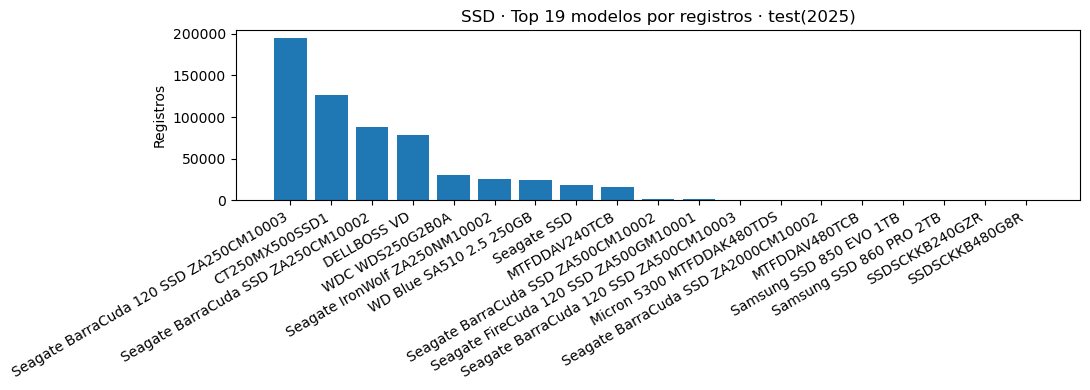

[train(2020-2024)] total modelos=23 | filas=3,344,856


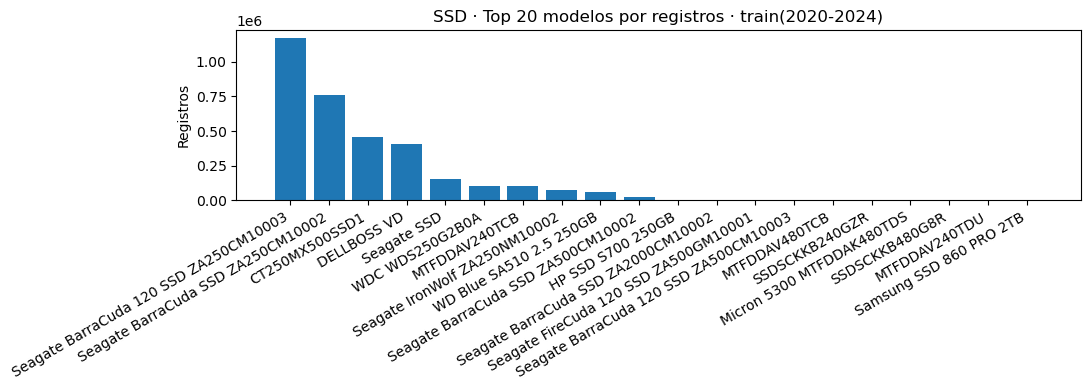


-- Incidencias por AÑO y MODELO (n0, n1, rows, %fallas) --
            part  year                                  model     n0  n1   rows  pct_fail
      test(2025)  2025 Seagate BarraCuda 120 SSD ZA250CM10003 194497   0 194497  0.000000
      test(2025)  2025                         CT250MX500SSD1 126954   0 126954  0.000000
      test(2025)  2025     Seagate BarraCuda SSD ZA250CM10002  88147   0  88147  0.000000
      test(2025)  2025                            DELLBOSS VD  77990   0  77990  0.000000
      test(2025)  2025                        WDC WDS250G2B0A  30767   0  30767  0.000000
      test(2025)  2025          Seagate IronWolf ZA250NM10002  26155   0  26155  0.000000
      test(2025)  2025                WD Blue SA510 2.5 250GB  24671   0  24671  0.000000
      test(2025)  2025                            Seagate SSD  17928   0  17928  0.000000
      test(2025)  2025                          MTFDDAV240TCB  15530   0  15530  0.000000
      test(2025)  2025     Seagate Barra

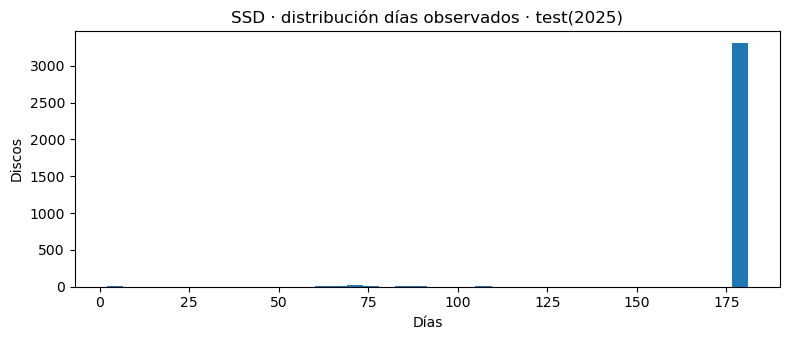

[train(2020-2024)] discos=3,788 | med días_obs=1152.0 | %discos con alguna falla=5.306%


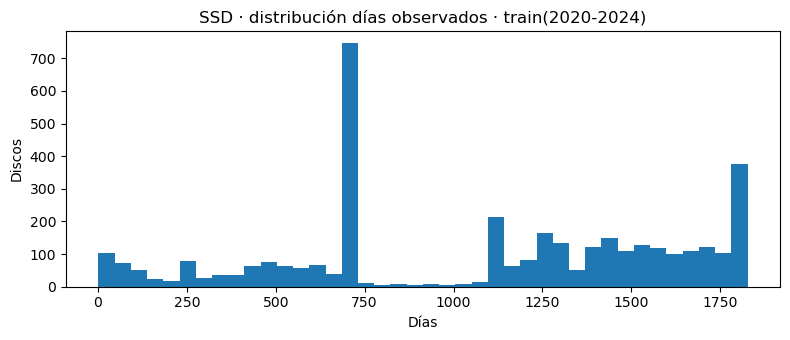


-- Lookahead (y=1 si hay falla en <= N días) --
[train(2020-2024)] N= 0 días -> %positivos = 0.00601%
[train(2020-2024)] N= 2 días -> %positivos = 0.01782%
[train(2020-2024)] N= 3 días -> %positivos = 0.02365%
[train(2020-2024)] N= 7 días -> %positivos = 0.04652%
[test(2025)] N= 0 días -> %positivos = 0.00000%
[test(2025)] N= 2 días -> %positivos = 0.00000%
[test(2025)] N= 3 días -> %positivos = 0.00000%
[test(2025)] N= 7 días -> %positivos = 0.00000%


In [ ]:
# SSD
eda_ssd = eda_backblaze_pro_gpu(
    parquet_train_path='./Procesados/finales/SSD_FULL_CLEAN.parquet',
    parquet_test2025_path='./Procesados/finales/SSD_FULL_CLEAN_2025.parquet',
    dataset_name='SSD',
    lookahead_grid=[0,2,3,7],         # ventanas cortas típicas para SSD
    rmm_pool_size="4.0GB",
    device_memory_limit="4.0GB",
    enable_cudf_spill=True,
    plot=True,                        # pon False si no quieres gráficas
    verbose=True,
    top_plot_models=20                # cuántos modelos dibujar
)



In [ ]:
# -*- coding: utf-8 -*-
import os, warnings, gc
warnings.filterwarnings("ignore")

import dask
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

import dask_cudf as dc
import cudf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def eda_backblaze_hdd_gpu(
    parquet_train_path,
    parquet_test2025_path=None,
    dataset_name='HDD',
    id_col='serial_number',
    date_col='date',
    label_col='failure',
    model_col='model',
    capacity_col='capacity_bytes',      # no lo explotamos aquí
    # --------- TUNING RECURSOS -------
    rmm_pool_size="4GB",
    device_memory_limit="4GB",
    enable_cudf_spill=True,
    threads_per_worker=1,
    # --------- VISUALIZACIÓN / LOG ----
    plot=False,                         # OFF por defecto (HDD tiene miles de modelos)
    plot_batch_size=250,                # cuántos modelos por figura si se plotea TODO
    verbose=True,
    max_print_rows=500                  # límite de filas a imprimir en consola
):
    """
    EDA Backblaze SOLO HDD (cuDF + Dask-cuDF), SIN LOOKAHEAD.

    - Overview (totales + por año) usando TODOS los registros (2020–2024 y 2025).
    - Incidencias por AÑO & MODELO (n0, n1, rows, %fallas) con TODOS los modelos.
    - Recuentos por MODELO (rows, discos, fallos) con TODOS los modelos.
    - Estadísticas por disco (días observados) en pandas.
    - Gráficos opcionales de Incidencias por AÑO & MODELO que cubren TODOS los modelos,
      generando varias figuras en lotes (plot_batch_size) si hay demasiados.

    Medidas de robustez y memoria:
      • Dask dataframe shuffle => 'tasks' (evita P2P).
      • Claves como string (sin category).
      • Pivots/merges en pandas tras compute().
      • days_obs en pandas con .dt.days.
    """

    # ---------- Config Dask: evitar P2P shuffle / tuning host RAM ----------
    dask.config.set({
        "dataframe.shuffle.method": "tasks",
        "optimization.fuse.active": True,
        "distributed.worker.memory.target": 0.85,
        "distributed.worker.memory.spill":  0.90,
        "distributed.worker.memory.pause":  0.95,
    })

    # ----------------------------
    # 0) Cluster local (1 GPU)
    # ----------------------------
    cluster = LocalCUDACluster(
        n_workers=1,                    # 1 GPU = 1 worker
        threads_per_worker=threads_per_worker,
        device_memory_limit=device_memory_limit,
        rmm_pool_size=rmm_pool_size,
        enable_cudf_spill=enable_cudf_spill,
        local_directory=os.environ.get("DASK_TEMPORARY_DIRECTORY", "./.dask-tmp")
    )
    client = Client(cluster)
    if verbose:
        print(client)

    # ----------------------------
    # Helpers
    # ----------------------------
    def _ensure_datetime_cu(ddf, col, fmt=None):
        def _cast_part(g):
            s = g[col]
            if str(s.dtype).startswith("datetime64"):
                return g
            try:
                g[col] = cudf.to_datetime(s, format=fmt)
            except Exception:
                try:
                    g[col] = cudf.to_datetime(s.astype('str'), format=fmt)
                except Exception:
                    g[col] = cudf.to_datetime(cudf.Series([''] * len(g)))
                    g[col] = g[col].where(False)  # all NaT
            return g
        out = ddf.map_partitions(_cast_part)
        out = out.dropna(subset=[col])
        return out

    def _overview_gpu(ddf_part):
        rows = int(ddf_part.shape[0].compute())
        ncols = int(len(ddf_part.columns))
        unique_disks = int(ddf_part[id_col].nunique().compute())
        dt_min = ddf_part[date_col].min().compute()
        dt_max = ddf_part[date_col].max().compute()
        years = sorted(pd.unique(ddf_part[date_col].dt.year.astype('int16').compute().to_pandas()).tolist())
        failures = int(ddf_part[label_col].sum().compute())
        n0 = rows - failures
        fail_rate_rows = 100.0 * failures / rows if rows else 0.0
        return {
            'rows': rows,
            'cols': ncols,
            'unique_disks': unique_disks,
            'date_min': dt_min,
            'date_max': dt_max,
            'years': years,
            'n0': n0,
            'n1': failures,
            'fail_rate_rows_%': fail_rate_rows
        }

    try:
        cudf.set_option("io.parquet.low_memory", True)
    except Exception:
        pass

    # ----------------------------
    # 1) Carga (train/test) + fechas
    # ----------------------------
    base_cols = [id_col, date_col, label_col, model_col, capacity_col]
    cols = [c for c in base_cols if isinstance(c, str)]

    def _read_parquet_gpu(path):
        if path is None:
            return None
        return dc.read_parquet(path, columns=cols, aggregate_files=True)

    ddf_tr = _read_parquet_gpu(parquet_train_path)
    ddf_te = _read_parquet_gpu(parquet_test2025_path) if parquet_test2025_path else None

    parts = {}
    if ddf_tr is not None:
        ddf_tr = ddf_tr.assign(part='train(2020-2024)')
        parts['train(2020-2024)'] = ddf_tr
    if ddf_te is not None:
        ddf_te = ddf_te.assign(part='test(2025)')
        parts['test(2025)'] = ddf_te

    # Limpieza de fecha
    for k in list(parts.keys()):
        parts[k] = _ensure_datetime_cu(parts[k], date_col, fmt=None)

    # Concatenado + dtypes seguros
    ddf = dc.concat(list(parts.values()), ignore_index=True)
    ddf = ddf.assign(
        year = ddf[date_col].dt.year.astype('int16'),
        part = ddf['part'].astype('str'),
    )
    ddf[id_col]    = ddf[id_col].astype('str')
    ddf[model_col] = ddf[model_col].astype('str')
    ddf[label_col] = ddf[label_col].astype('int8')

    # ----------------------------
    # 2) OVERVIEW (por parte y total) + POR AÑO
    # ----------------------------
    over = {}
    for tag, ddf_part in parts.items():
        over[tag] = _overview_gpu(ddf_part)
    over['_TOTAL_'] = _overview_gpu(ddf)

    if verbose:
        print(f"\n==== {dataset_name} :: OVERVIEW ====")
        for k, v in over.items():
            print(f"[{k}] rows={v['rows']:,} | cols={v['cols']} | disks={v['unique_disks']:,} | "
                  f"date=[{v['date_min'].date()}..{v['date_max'].date()}] | years={v['years']} | "
                  f"n0={v['n0']:,} | n1={v['n1']:,} | %fail={v['fail_rate_rows_%']:.5f}%")

    # Por año con todos los datos
    gy = (ddf.groupby(['part', 'year', label_col])
            .size().rename('n').reset_index()).compute().to_pandas()
    per_year = (gy.pivot_table(index=['part','year'], columns=label_col, values='n',
                               fill_value=0, aggfunc='sum')
                  .rename(columns={0:'n0', 1:'n1'})
                  .reset_index())
    per_year['rows']  = per_year['n0'] + per_year['n1']
    per_year['pct_fail'] = np.where(per_year['rows']>0, 100.0*per_year['n1']/per_year['rows'], 0.0)

    if verbose:
        print("\n-- Por AÑO (filas, n0, n1, rows, %fallas) --")
        if len(per_year) <= max_print_rows:
            print(per_year.sort_values(['part','year']).to_string(index=False))
        else:
            print(f"Tabla grande: {len(per_year):,} filas. Mostrando primeras/últimas 5.")
            print(per_year.sort_values(['part','year']).head(5).to_string(index=False))
            print("...")
            print(per_year.sort_values(['part','year']).tail(5).to_string(index=False))

    # ----------------------------
    # 3) MODELOS: recuentos (TODOS los modelos)
    # ----------------------------
    rows_by_model_pd = (ddf.groupby(['part', model_col]).size()
                          .rename('rows').reset_index()).compute().to_pandas()
    disks_by_model_pd = (ddf.groupby(['part', model_col])[id_col]
                           .nunique().rename('disks').reset_index()).compute().to_pandas()
    fails_by_model_pd = (ddf.groupby(['part', model_col])[label_col]
                           .sum().rename('n1').reset_index()).compute().to_pandas()

    by_model = (rows_by_model_pd
                .merge(disks_by_model_pd, on=['part', model_col], how='left')
                .merge(fails_by_model_pd, on=['part', model_col], how='left'))
    by_model['n1'] = by_model['n1'].fillna(0).astype(np.int64)
    by_model['fail_rate'] = np.where(by_model['rows']>0, by_model['n1']/by_model['rows'], 0.0)
    by_model = by_model.sort_values(['part','rows'], ascending=[True, False])

    if verbose:
        print("\n-- Modelos por parte (TODOS) --")
        for part_name, sub in by_model.groupby('part'):
            print(f"[{part_name}] modelos={sub[model_col].nunique()} | filas={int(sub['rows'].sum()):,}")
            if len(sub) <= max_print_rows:
                print(sub[[model_col,'rows','disks','n1','fail_rate']].to_string(index=False))
            else:
                print(f"  Tabla grande: {len(sub):,} filas. Mostrando primeras/últimas 5.")
                print(sub[[model_col,'rows','disks','n1','fail_rate']].head(5).to_string(index=False))
                print("...")
                print(sub[[model_col,'rows','disks','n1','fail_rate']].tail(5).to_string(index=False))

    # ----------------------------
    # 4) INCIDENCIAS por AÑO y MODELO (TODOS los modelos)
    # ----------------------------
    gym_pd = (ddf.groupby(['part','year', model_col, label_col])
                .size().rename('n').reset_index()).compute().to_pandas()

    per_year_model = (gym_pd.pivot_table(index=['part','year', model_col],
                                         columns=label_col, values='n',
                                         fill_value=0, aggfunc='sum')
                        .rename(columns={0:'n0', 1:'n1'})
                        .reset_index())
    per_year_model['rows'] = per_year_model['n0'] + per_year_model['n1']
    per_year_model['pct_fail'] = np.where(per_year_model['rows']>0,
                                          100.0*per_year_model['n1']/per_year_model['rows'], 0.0)

    if verbose:
        print("\n-- Incidencias por AÑO y MODELO (TODOS) --")
        if len(per_year_model) <= max_print_rows:
            print(per_year_model.sort_values(['part','year','rows'], ascending=[True, True, False])
                  .to_string(index=False))
        else:
            print(f"Tabla grande: {len(per_year_model):,} filas. Mostrando primeras/últimas 5.")
            tmp = per_year_model.sort_values(['part','year','rows'], ascending=[True, True, False])
            print(tmp.head(5).to_string(index=False))
            print("...")
            print(tmp.tail(5).to_string(index=False))

    # --- Gráficos opcionales: abarcan TODOS los modelos, en lotes por año ---
    if plot:
        for part_name, subp in per_year_model.groupby('part'):
            for y, suby in subp.groupby('year'):
                suby = suby.sort_values('rows', ascending=False)
                total = len(suby)
                # dividir en lotes para no saturar
                for i in range(0, total, plot_batch_size):
                    chunk = suby.iloc[i:i+plot_batch_size]
                    plt.figure(figsize=(max(12, min(24, 0.25*len(chunk))), 4.5))
                    plt.bar(range(len(chunk)), chunk['rows'])
                    plt.xticks(range(len(chunk)), chunk[model_col], rotation=30, ha='right', fontsize=8)
                    plt.ylabel('Registros')
                    plt.title(f'{dataset_name} · Incidencias por AÑO y MODELO · {part_name} · {y} · modelos {i+1}-{i+len(chunk)} de {total}')
                    plt.tight_layout(); plt.show()

    # ----------------------------
    # 5) Estadística por DISCO (reset_index + days en pandas)
    # ----------------------------
    ds_ddf = (ddf.groupby(['part', id_col])
                .agg({date_col: ['min','max'], label_col: ['max']})).reset_index()
    ds_pd = ds_ddf.compute().to_pandas()
    ds_pd.columns = ['part', id_col, 'first_date', 'last_date', 'any_fail']
    ds_pd['days_obs'] = (ds_pd['last_date'] - ds_pd['first_date']).dt.days + 1
    disk_stats = ds_pd

    if verbose:
        for part_name, sub in disk_stats.groupby('part'):
            pct_fail_disks = 100.0 * sub['any_fail'].mean()
            med_days = float(sub['days_obs'].median()) if len(sub) else 0.0
            print(f"\n[{part_name}] discos={sub[id_col].nunique():,} | med días_obs={med_days:.1f} | %discos con alguna falla={pct_fail_disks:.3f}%")

    del ds_ddf; gc.collect()

    # ----------------------------
    # Retorno
    # ----------------------------
    result = {
        'overview': over,                     # dict por parte + _TOTAL_
        'per_year': per_year,                 # DataFrame (pandas)
        'by_model': by_model,                 # DataFrame (pandas)
        'per_year_model': per_year_model,     # DataFrame (pandas)
        'disk_stats': disk_stats,             # DataFrame (pandas)
    }

    client.close(); cluster.close()
    gc.collect()
    return result


<Client: 'tcp://127.0.0.1:45061' processes=1 threads=1, memory=12.00 GiB>

==== HDD :: OVERVIEW ====
[train(2020-2024)] rows=319,921,612 | cols=6 | disks=384,896 | date=[2020-01-01..2024-12-31] | years=[2020, 2021, 2022, 2023, 2024] | n0=319,908,932 | n1=12,680 | %fail=0.00396%
[test(2025)] rows=55,999,545 | cols=6 | disks=324,476 | date=[2025-01-01..2025-06-30] | years=[2025] | n0=55,997,417 | n1=2,128 | %fail=0.00380%
[_TOTAL_] rows=375,921,157 | cols=7 | disks=407,286 | date=[2020-01-01..2025-06-30] | years=[2020, 2021, 2022, 2023, 2024, 2025] | n0=375,906,349 | n1=14,808 | %fail=0.00394%

-- Por AÑO (filas, n0, n1, rows, %fallas) --
            part  year        n0   n1      rows  pct_fail
      test(2025)  2025  55997417 2128  55999545  0.003800
train(2020-2024)  2020  52002980 1492  52004472  0.002869
train(2020-2024)  2021  66659067 2027  66661094  0.003041
train(2020-2024)  2022   6550792  206   6550998  0.003145
train(2020-2024)  2023  90541711 4321  90546032  0.004772
train(2

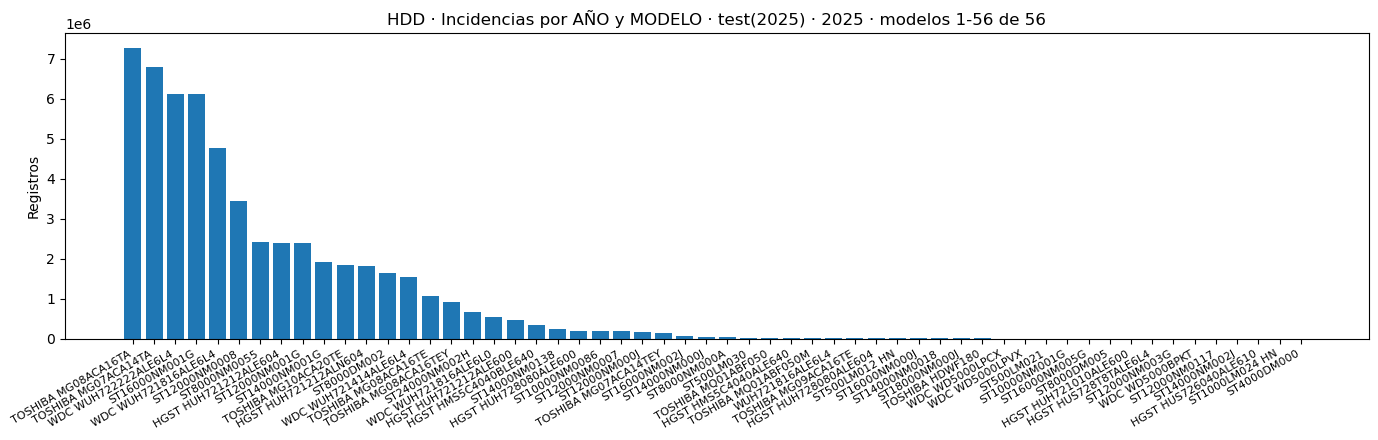

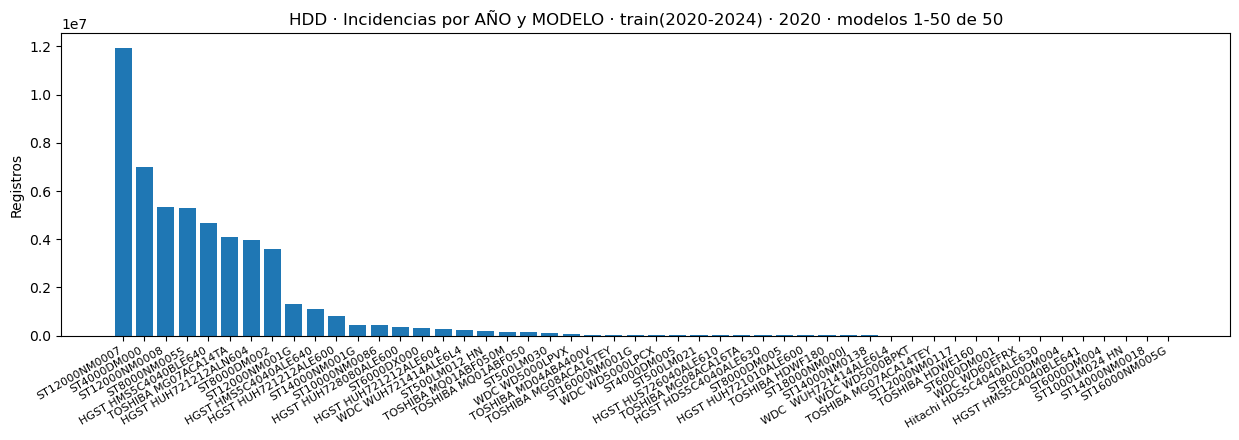

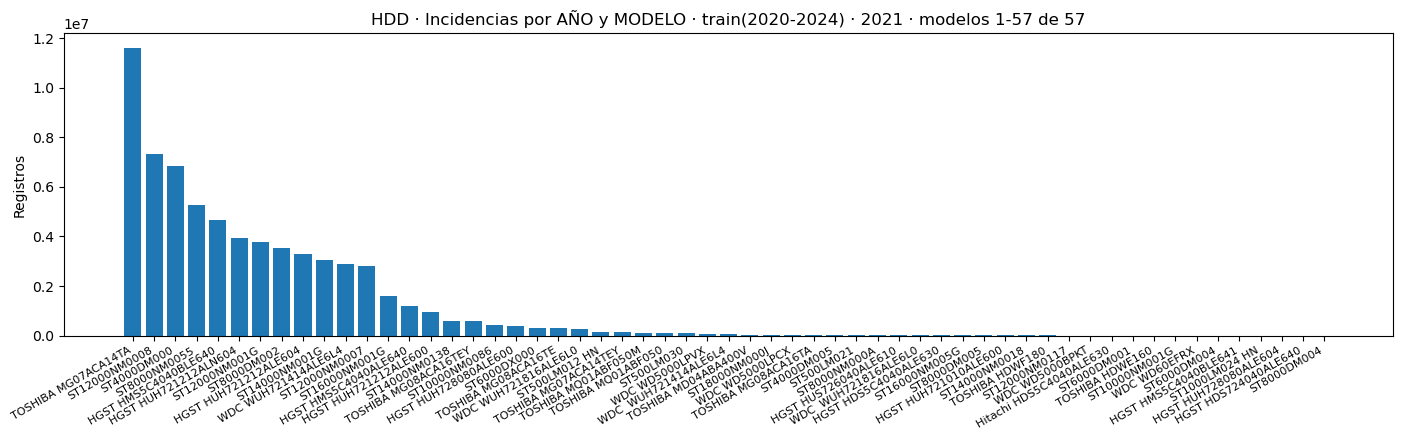

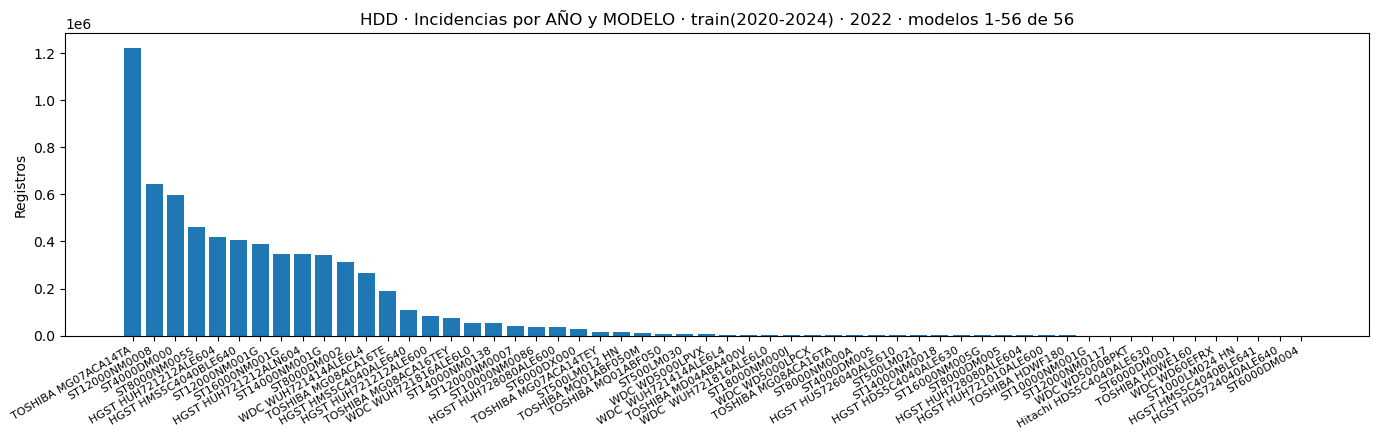

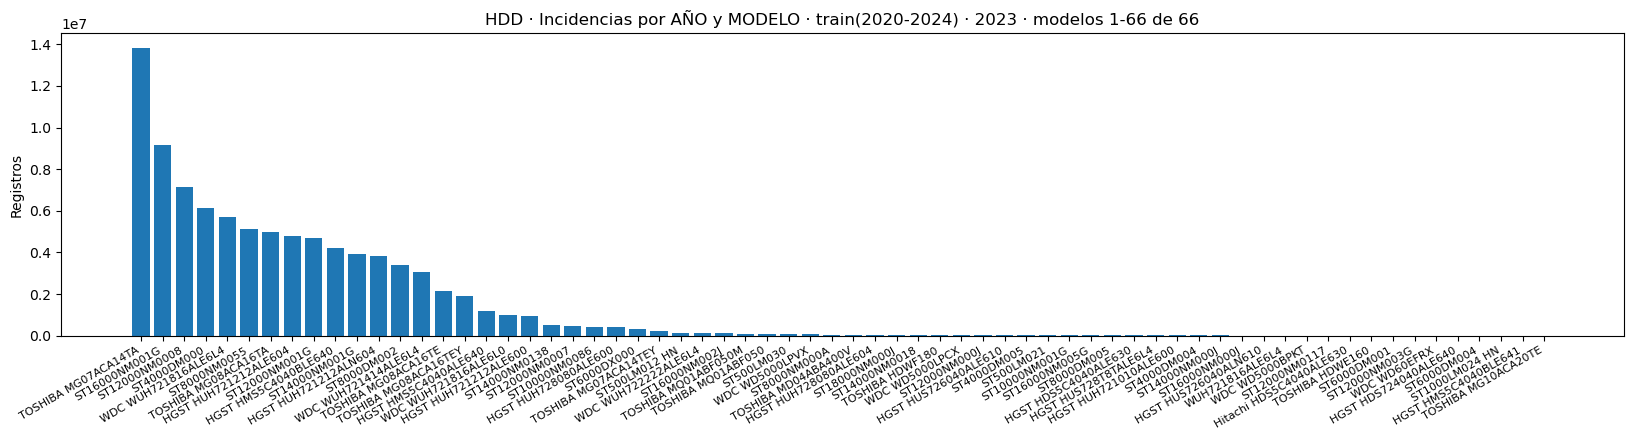

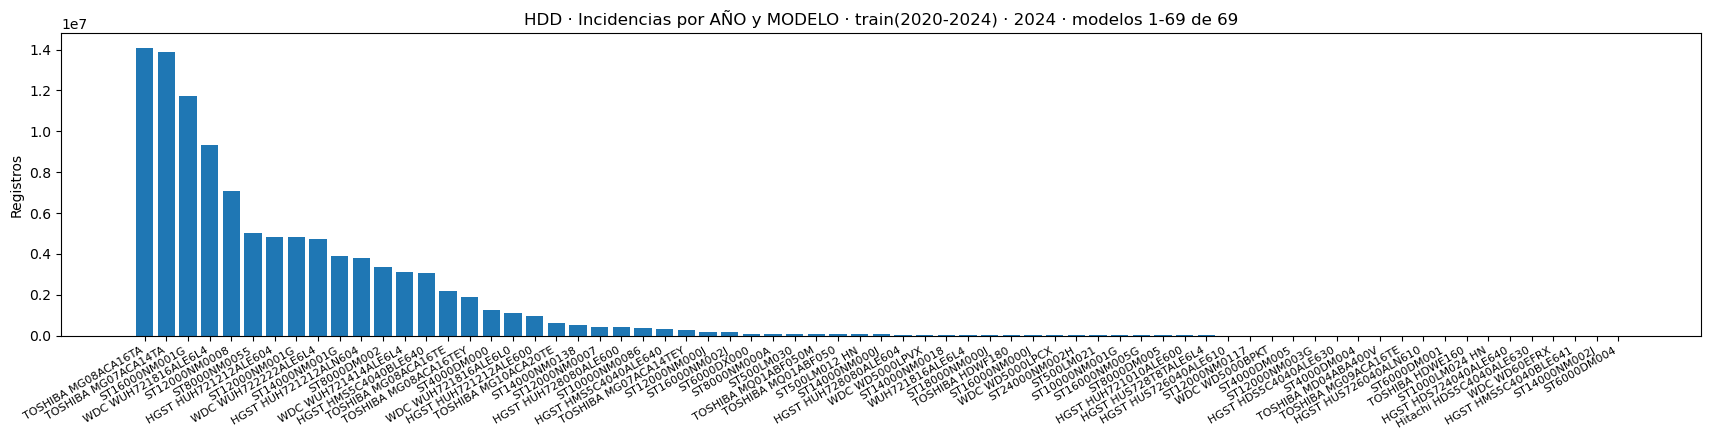


[test(2025)] discos=324,476 | med días_obs=181.0 | %discos con alguna falla=0.656%

[train(2020-2024)] discos=384,896 | med días_obs=1133.0 | %discos con alguna falla=3.293%


In [ ]:
eda_hdd = eda_backblaze_hdd_gpu(
    parquet_train_path='./Procesados/finales/HDD_FULL_CLEAN.parquet',
    parquet_test2025_path='./Procesados/finales/HDD_FULL_CLEAN_2025.parquet',
    dataset_name='HDD',
    rmm_pool_size="4GB",
    device_memory_limit="4GB",
    enable_cudf_spill=True,
    threads_per_worker=1,
    plot=True,
    plot_batch_size=250,
    verbose=True,
    max_print_rows=500
)


In [ ]:
import pyarrow.parquet as pq

def parquet_info(file_path):
    pf = pq.ParquetFile(file_path)
    num_row_groups = pf.num_row_groups
    num_columns = len(pf.schema.names)
    # Contar filas sin cargar todo (sumar filas de todos los row groups)
    total_rows = sum([pf.metadata.row_group(i).num_rows for i in range(num_row_groups)])
    columns = pf.schema.names
    print(f"\nArchivo: {file_path}")
    print(f"Filas (registros): {total_rows}")
    print(f"Columnas: {num_columns}")
    print(f"Nombres de columnas: {columns}")
    # Muestra primeras 5 filas sin cargar todo el DataFrame
    table_head = pf.read_row_group(0).to_pandas().head()
    print("\nPrimeros registros:")
    print(table_head)

# Rutas de los archivos
hdd_file = './Procesados/finales/HDD_FULL_CLEAN.parquet'
ssd_file = './Procesados/finales/SSD_FULL_CLEAN.parquet'

parquet_info(hdd_file)
parquet_info(ssd_file)



Archivo: ./Procesados/finales/HDD_FULL_CLEAN.parquet
Filas (registros): 319921612
Columnas: 10
Nombres de columnas: ['model', 'date', 'failure', 'serial_number', 'capacity_bytes', 'smart_5_raw', 'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw']

Primeros registros:
                  model       date  failure   serial_number  capacity_bytes  \
0           ST4000DM000 2020-01-01        0        Z305B2QN   4000787030016   
1         ST12000NM0007 2020-01-01        0        ZJV0XJQ4  12000138625024   
2         ST12000NM0007 2020-01-01        0        ZJV0XJQ3  12000138625024   
3         ST12000NM0007 2020-01-01        0        ZJV0XJQ0  12000138625024   
4  HGST HMS5C4040ALE640 2020-01-01        0  PL1331LAHG1S4H   4000787030016   

   smart_5_raw  smart_187_raw  smart_188_raw  smart_197_raw  smart_198_raw  
0          0.0            0.0            0.0            0.0            0.0  
1          0.0            0.0            0.0            0.0            0.0  
2        